<a href="https://colab.research.google.com/github/Nyon0k/MVP-Machine-Learning---Especializacao-Ciencia-de-Dados-e-Analytics---PUCRJ/blob/main/ml_sprint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gerador da Base de Dados Fictícia

In [ ]:
# -*- coding: utf-8 -*-
"""
Gera base sintética de risco de crédito em Parquet com campos de PD/PE:
- Campos adicionados: ead, lgd, valor_recuperado, pd_true, pd_model
- Salva em Parquet (requer pyarrow)
"""

import numpy as np
import pandas as pd
from datetime import datetime

# =========================
# PARÂMETROS
# =========================
N = 1_000_000                # nº de linhas
SEED = 42
TARGET_DEFAULT_RATE = 0.12   # taxa alvo global de default (calibração da pd_true)
OUT_PARQUET = "dados_ficticios_risco_credito.parquet"

np.random.seed(SEED)

# =========================
# HELPERS
# =========================
def random_dates(n, start, end):
    delta_days = (end - start).days
    return pd.to_datetime(start) + pd.to_timedelta(
        np.random.randint(0, delta_days + 1, n), unit="D"
    )

def logistic(z):
    return 1 / (1 + np.exp(-z))

def annuity_payment(principal, monthly_rate, months):
    mr = monthly_rate
    with np.errstate(divide='ignore', invalid='ignore'):
        num = principal * mr * (1 + mr) ** months
        den = (1 + mr) ** months - 1
        pmt = np.where(np.isclose(mr, 0), principal / months, num / den)
    return np.clip(pmt, 0, None)

# =========================
# GERAÇÃO DA BASE
# =========================
start_date = pd.Timestamp("2018-01-01")
end_date   = pd.Timestamp("2026-07-31")

ufs = np.array(["SP","RJ","MG","RS","BA","PE","PR","SC","GO","DF"])
regiao_map = {
    "SP": "Sudeste", "RJ": "Sudeste", "MG": "Sudeste",
    "RS": "Sul", "PR": "Sul", "SC": "Sul",
    "BA": "Nordeste", "PE": "Nordeste",
    "GO": "Centro-Oeste", "DF": "Centro-Oeste",
}
canais = np.array(["Agência","App","Internet Banking","Correspondente"])
produtos = np.array(["Pessoal","Consignado","Veículo","Cartão","Home_Equity"])
escolaridade = np.array(["Fundamental","Médio","Superior","Pós"])
estado_civil = np.array(["Solteiro","Casado","Divorciado","Viúvo"])
vinculo_emprego = np.array(["CLT","Servidor","Autônomo","Empresário","Desempregado"])
setores = np.array(["Serviços","Indústria","Comércio","TI","Saúde","Educação","Construção"])

df = pd.DataFrame({
    "id_cliente": np.arange(1, N+1, dtype=np.int64),
    "data_solicitacao": random_dates(N, start_date, end_date),
    "uf": np.random.choice(ufs, N, p=[0.30,0.12,0.18,0.08,0.08,0.06,0.07,0.05,0.04,0.02]),
})
df["regiao"] = df["uf"].map(regiao_map)

# Demografia e relacionamento
df["idade"] = np.clip(np.random.normal(38, 10, N).round(), 18, 70).astype(int)
tempo_conta = np.random.lognormal(mean=np.log(4.0), sigma=0.7, size=N)
df["tempo_conta_anos"] = np.clip(tempo_conta, 0, 25).round(1)
df["canal"] = np.random.choice(canais, N, p=[0.35,0.30,0.20,0.15])
df["produto"] = np.random.choice(produtos, N, p=[0.45,0.20,0.15,0.15,0.05])
df["escolaridade"] = np.random.choice(escolaridade, N, p=[0.20,0.40,0.30,0.10])
df["estado_civil"] = np.random.choice(estado_civil, N, p=[0.45,0.40,0.12,0.03])
df["vinculo_emprego"] = np.random.choice(vinculo_emprego, N, p=[0.55,0.10,0.20,0.10,0.05])
df["setor"] = np.random.choice(setores, N)

# Uso de serviços
df["usa_internet_banking"] = np.random.rand(N) < np.where(df["canal"].eq("Agência"), 0.45, 0.75)
df["possui_cartao_credito"] = np.random.rand(N) < 0.65
df["possui_investimentos"] = np.random.rand(N) < np.where(df["escolaridade"].isin(["Superior","Pós"]), 0.45, 0.20)
df["possui_seguro"] = np.random.rand(N) < 0.30
df["qtd_produtos_bancarios"] = (
    1
    + df["possui_cartao_credito"].astype(int)
    + df["possui_investimentos"].astype(int)
    + df["possui_seguro"].astype(int)
)

# Renda
mu_base = {"CLT": 9.5, "Servidor": 9.8, "Autônomo": 9.3, "Empresário": 10.1, "Desempregado": 8.5}
sigma_base = 0.55
mu = df["vinculo_emprego"].map(mu_base).astype(float).values
esc_adj = df["escolaridade"].map({"Fundamental":-0.25,"Médio":0.0,"Superior":0.25,"Pós":0.45}).values
mu = mu + esc_adj
renda_atual = np.random.lognormal(mean=mu, sigma=sigma_base, size=N)
renda_atual = np.clip(renda_atual, 500, 60_000)
df["renda_mensal_atual"] = np.round(renda_atual, 2)
eps = np.random.normal(0, 0.08, N)
df["renda_mensal_anterior"] = np.round(df["renda_mensal_atual"] * (0.90 + eps), 2)

# Score + atrasos
base_score = np.clip(np.random.normal(600, 120, N), 300, 900)
lambda_atraso = np.exp(1.2 - (base_score - 600)/250)
df["atrasos_passados"] = np.random.poisson(lambda_atraso).astype(int)
adj_score = (
    base_score
    + 0.0008 * (df["renda_mensal_atual"].values - 4000)
    - 25 * np.clip(df["atrasos_passados"].values, 0, 5)
    + 5 * df["qtd_produtos_bancarios"].values
    + 8 * (df["tempo_conta_anos"].values)
)
df["score_credito"] = np.clip(adj_score, 300, 900).round().astype(int)

# Prazos por produto
prazo_choices = {
    "Pessoal":   [6,12,18,24,36],
    "Consignado":[12,24,36,48,60],
    "Veículo":   [24,36,48,60],
    "Cartão":    [6,12,18,24],
    "Home_Equity":[60,120,180]
}
df["parcelas"] = [np.random.choice(prazo_choices[p]) for p in df["produto"].values]

# Ticket por produto + coerência com renda
ticket_mu = {"Pessoal": 10.0, "Consignado": 10.2, "Veículo": 10.5, "Cartão": 9.2, "Home_Equity": 12.0}
ticket_sigma = {"Pessoal": 0.8, "Consignado": 0.7, "Veículo": 0.7, "Cartão": 0.6, "Home_Equity": 0.9}
valores = np.array([np.random.lognormal(ticket_mu[p], ticket_sigma[p]) for p in df["produto"].values])
multiplicador_renda = np.where(df["produto"].eq("Home_Equity"), 30, 12)
tetos = {"Pessoal": 80_000, "Consignado": 100_000, "Veículo": 200_000, "Cartão": 20_000, "Home_Equity": 1_000_000}
max_por_prod = np.array([tetos[p] for p in df["produto"].values])
upper_cap = np.minimum(max_por_prod, multiplicador_renda * df["renda_mensal_atual"].values)
df["valor_emprestimo"] = np.round(np.clip(valores, 300, upper_cap), 2)

# Juros, parcela e DTI
prod_spread = df["produto"].map({"Pessoal":0.025,"Consignado":0.015,"Veículo":0.018,"Cartão":0.03,"Home_Equity":0.012}).values
score_penalty = np.clip((650 - df["score_credito"].values)/1000, 0, 0.02)
tx_m = prod_spread + score_penalty + np.random.normal(0, 0.002, N)
tx_m = np.clip(tx_m, 0.005, 0.04)
df["taxa_juros_mensal"] = np.round(tx_m, 4)

meses = df["parcelas"].values.astype(int)
prest = annuity_payment(df["valor_emprestimo"].values, df["taxa_juros_mensal"].values, meses)
df["valor_parcela"] = np.round(prest, 2)
df["dti"] = np.round(np.where(df["renda_mensal_atual"]>0, df["valor_parcela"]/df["renda_mensal_atual"], np.nan), 3)

# Transações e histórico
df["frequencia_transacoes"] = np.random.poisson(lam=12 + 6*df["usa_internet_banking"].astype(int) + 3*df["possui_cartao_credito"].astype(int)).astype(int)
df["valor_emprestimos_anteriores"] = np.round(np.random.exponential(8000, N) * (1 + 0.4*df["qtd_produtos_bancarios"].values), 2)

# Drift temporal
months_from_start = (df["data_solicitacao"].values.astype('datetime64[M]') - np.datetime64(start_date, 'M')).astype(int)
time_drift = -0.01 * (months_from_start / months_from_start.max())

# PD verdadeira e rótulo
z = (
    -2.0
    + time_drift
    + 0.00008 * (df["valor_emprestimo"].values - 10_000)
    + 2.2 * np.clip(df["dti"].fillna(df["dti"].median()).values - 0.25, 0, None)
    + 0.45 * (df["atrasos_passados"].values)
    - 0.006 * (df["score_credito"].values - 600)
    - 0.00003 * (df["renda_mensal_atual"].values - 4000)
    - 0.03 * (df["tempo_conta_anos"].values)
    - 0.05 * (df["qtd_produtos_bancarios"].values - 2)
    - 0.12 * df["possui_investimentos"].astype(int).values
    - 0.08 * df["usa_internet_banking"].astype(int).values
)
efeito_prod = {"Pessoal":0.10,"Consignado":-0.25,"Veículo":-0.05,"Cartão":0.20,"Home_Equity":-0.35}
efeito_canal = {"Agência":0.05,"App":-0.05,"Internet Banking":-0.08,"Correspondente":0.12}
efeito_uf = {"SP":-0.05,"RJ":0.06,"MG":-0.02,"RS":0.0,"BA":0.05,"PE":0.05,"PR":-0.01,"SC":-0.02,"GO":0.02,"DF":-0.01}
z += df["produto"].map(efeito_prod).values
z += df["canal"].map(efeito_canal).values
z += df["uf"].map(efeito_uf).values
z += np.random.normal(0, 0.4, N)

p_default = logistic(z)

# calibração global para TARGET_DEFAULT_RATE
actual_rate = p_default.mean()
if 0 < actual_rate < 1:
    adj = np.log(TARGET_DEFAULT_RATE/(1-TARGET_DEFAULT_RATE)) - np.log(actual_rate/(1-actual_rate))
    logit = np.log(p_default/(1 - p_default))
    p_default = logistic(logit + adj)

df["pd_true"] = p_default
df["inadimplente"] = (np.random.rand(N) < p_default).astype(int)

# Risco: EAD, LGD, valor_recuperado
df["ead"] = df["valor_emprestimo"]
lgd_alpha_beta = {
    "Pessoal": (7,3),        # ~0.70
    "Consignado": (3,7),     # ~0.30
    "Veículo": (4.5,5.5),    # ~0.45
    "Cartão": (8.5,1.5),     # ~0.85
    "Home_Equity": (2.5,7.5) # ~0.25
}
alphas = np.array([lgd_alpha_beta[p][0] for p in df["produto"].values])
betas  = np.array([lgd_alpha_beta[p][1] for p in df["produto"].values])
lgd = np.random.beta(alphas, betas)
lgd += df["uf"].map({"RJ":0.02,"BA":0.02,"PE":0.02,"SP":-0.01,"SC":-0.01}).fillna(0).values
lgd += df["canal"].map({"Correspondente":0.02,"Internet Banking":-0.01}).fillna(0).values
lgd = np.clip(lgd, 0.05, 0.95)
df["lgd"] = np.round(lgd, 4)

recuperado = np.zeros(N, dtype=float)
mask_def = df["inadimplente"].values == 1
ruido_rec = np.ones(N)
ruido_rec[mask_def] = np.random.lognormal(mean=-0.05, sigma=0.35, size=mask_def.sum())
recuperado[mask_def] = (1 - df.loc[mask_def, "lgd"].values) * df.loc[mask_def, "ead"].values * ruido_rec[mask_def]
recuperado = np.clip(recuperado, 0, df["ead"].values)
df["valor_recuperado"] = np.round(recuperado, 2)

# pd_model: “modelo” sintético (ruído + leve descalibração)
logit_true = np.log(df["pd_true"].clip(1e-9, 1-1e-9) / (1 - df["pd_true"].clip(1e-9, 1-1e-9)))
noise = np.random.normal(0, 0.5, N)
logit_model = 0.9 * logit_true + 0.2 + noise
df["pd_model"] = logistic(logit_model).clip(1e-6, 1-1e-6)

# Faltantes / outliers leves
mask_no_ib = ~df["usa_internet_banking"]
miss_prob = np.where(mask_no_ib, 0.15, 0.03)
for col in ["renda_mensal_atual","renda_mensal_anterior","tempo_emprego_anos","valor_emprestimos_anteriores"]:
    if col == "tempo_emprego_anos" and col not in df.columns:
        base_te = np.clip(np.random.lognormal(mean=1.2, sigma=0.7, size=N), 0, 40)
        base_te = np.where(df["vinculo_emprego"].eq("Desempregado"), 0, base_te)
        df[col] = np.round(base_te, 1)
    m = (np.random.rand(N) < miss_prob)
    df.loc[m & (np.random.rand(N) < 0.5), col] = np.nan

df.loc[np.random.rand(N) < 0.001, "renda_mensal_atual"] *= 5
df.loc[np.random.rand(N) < 0.001, "valor_emprestimo"] *= 3
df["renda_mensal_atual"] = df["renda_mensal_atual"].clip(0, 120_000).round(2)
df["valor_emprestimo"] = df["valor_emprestimo"].clip(300, 2_000_000).round(2)

# =========================
# SALVAR EM PARQUET
# =========================
try:
    import pyarrow  # noqa: F401
except Exception as e:
    raise RuntimeError("Instale o pacote 'pyarrow' para salvar Parquet: pip install pyarrow") from e

df.to_parquet(OUT_PARQUET, index=False)
print(f"OK! Parquet salvo em: {OUT_PARQUET}\nLinhas: {len(df)} | default_rate: {df['inadimplente'].mean():.4f}")

## Modelagem da Probability Default (PD)

### 1 - Leitura da Base Original

In [ ]:
import pandas as pd

# Link compartilhado do Google Drive
url = "https://drive.google.com/file/d/14yuZrUKYQiGhceAF4rYOoQF5G2Mgxx2A/view?usp=sharing"

# Transforma em link de download direto
file_id = url.split("/d/")[1].split("/")[0]
download_url = f"https://drive.google.com/uc?id={file_id}"

# Ler parquet diretamente
df = pd.read_parquet(download_url)
display(df.head())
display(df.columns)

,id_cliente,data_solicitacao,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,...,dti,frequencia_transacoes,valor_emprestimos_anteriores,pd_true,inadimplente,ead,lgd,valor_recuperado,pd_model,tempo_emprego_anos
0,1,2020-05-10,SP,Sudeste,22,12.5,App,Consignado,Médio,Solteiro,...,0.428,27,6505.86,0.972430,1,100000.00,0.3752,60551.22,0.968309,3.7
1,2,2021-07-18,RJ,Sudeste,30,2.4,App,Veículo,Fundamental,Divorciado,...,0.114,21,15534.02,0.786743,1,44847.64,0.3147,41706.49,0.817926,6.3
2,3,2021-02-04,SP,Sudeste,24,5.2,App,Pessoal,Médio,Solteiro,...,0.307,14,38994.06,0.126965,0,12290.31,0.5638,0.00,0.067548,1.6
3,4,2020-12-31,PE,Nordeste,40,3.6,App,Consignado,Médio,Solteiro,...,0.038,18,40463.28,0.312604,0,18890.04,0.1875,0.00,0.388200,1.2
4,5,2026-06-20,PE,Nordeste,35,3.0,Internet Banking,Veículo,Pós,Casado,...,0.084,16,8292.18,0.973499,1,68525.62,0.6273,25505.39,0.973559,5.8


Index(['id_cliente', 'data_solicitacao', 'uf', 'regiao', 'idade',
       'tempo_conta_anos', 'canal', 'produto', 'escolaridade', 'estado_civil',
       'vinculo_emprego', 'setor', 'usa_internet_banking',
       'possui_cartao_credito', 'possui_investimentos', 'possui_seguro',
       'qtd_produtos_bancarios', 'renda_mensal_atual', 'renda_mensal_anterior',
       'atrasos_passados', 'score_credito', 'parcelas', 'valor_emprestimo',
       'taxa_juros_mensal', 'valor_parcela', 'dti', 'frequencia_transacoes',
       'valor_emprestimos_anteriores', 'pd_true', 'inadimplente', 'ead', 'lgd',
       'valor_recuperado', 'pd_model', 'tempo_emprego_anos'],
      dtype='object')

### 2 - Preprocessamento da Base

In [ ]:
# Contar valores nulos por coluna
nulos_por_coluna = df.isnull().sum()
total_linhas = len(df)

# Criar DataFrame com quantidade e percentual
nulos_df = pd.DataFrame({
    "Coluna": nulos_por_coluna.index,
    "Qtd_Nulos": nulos_por_coluna.values,
    "Percentual_Nulos": (nulos_por_coluna.values / total_linhas) * 100
})

# Ordenar pelo número de nulos
nulos_df = nulos_df.sort_values(by="Qtd_Nulos", ascending=False)

print(nulos_df)

                          Coluna  Qtd_Nulos  Percentual_Nulos
27  valor_emprestimos_anteriores      36604            3.6604
34            tempo_emprego_anos      36398            3.6398
17            renda_mensal_atual      36361            3.6361
18         renda_mensal_anterior      36096            3.6096
2                             uf          0            0.0000
0                     id_cliente          0            0.0000
1               data_solicitacao          0            0.0000
7                        produto          0            0.0000
8                   escolaridade          0            0.0000
3                         regiao          0            0.0000
4                          idade          0            0.0000
10               vinculo_emprego          0            0.0000
9                   estado_civil          0            0.0000
11                         setor          0            0.0000
12          usa_internet_banking          0            0.0000
14      

* Menos de 5% dos valores sao nulos nas colunas renda_mensal_atual, tempo_emprego_anos, valor_emprestimos_anteriores e renda_mensal_anterior. Iremos seguir com esses valores nulos

In [ ]:
# Contar valores distintos (exclui NaN por padrão)
qtd_distintos = df["data_solicitacao"].unique()

display(qtd_distintos)
print("Valores distintos (sem contar NaN):", qtd_distintos)

<DatetimeArray>
['2020-05-10 00:00:00', '2021-07-18 00:00:00', '2021-02-04 00:00:00',
 '2020-12-31 00:00:00', '2026-06-20 00:00:00', '2022-06-27 00:00:00',
 '2023-12-10 00:00:00', '2019-04-12 00:00:00', '2021-05-23 00:00:00',
 '2018-11-27 00:00:00',
 ...
 '2020-10-07 00:00:00', '2025-02-22 00:00:00', '2020-07-16 00:00:00',
 '2026-07-03 00:00:00', '2026-03-31 00:00:00', '2020-01-07 00:00:00',
 '2026-05-02 00:00:00', '2022-09-27 00:00:00', '2018-09-09 00:00:00',
 '2021-06-15 00:00:00']
Length: 3134, dtype: datetime64[ns]

Valores distintos (sem contar NaN): <DatetimeArray>
['2020-05-10 00:00:00', '2021-07-18 00:00:00', '2021-02-04 00:00:00',
 '2020-12-31 00:00:00', '2026-06-20 00:00:00', '2022-06-27 00:00:00',
 '2023-12-10 00:00:00', '2019-04-12 00:00:00', '2021-05-23 00:00:00',
 '2018-11-27 00:00:00',
 ...
 '2020-10-07 00:00:00', '2025-02-22 00:00:00', '2020-07-16 00:00:00',
 '2026-07-03 00:00:00', '2026-03-31 00:00:00', '2020-01-07 00:00:00',
 '2026-05-02 00:00:00', '2022-09-27 00:00:00', '2018-09-09 00:00:00',
 '2021-06-15 00:00:00']
Length: 3134, dtype: datetime64[ns]


In [ ]:
# Filtrar onde Col2 é nulo
filtro_nulos = df[df["renda_mensal_anterior"].isnull()]

# Contar combinações
resultado = filtro_nulos.groupby("vinculo_emprego").size().reset_index(name="Qtd_Nulos_Col2")

print(resultado)

  vinculo_emprego  Qtd_Nulos_Col2
0        Autônomo            7167
1             CLT           19910
2    Desempregado            1826
3      Empresário            3528
4        Servidor            3665


In [ ]:
# garantir que é datetime
df['data_solicitacao'] = pd.to_datetime(df['data_solicitacao'])

# 1) Em string para exibição: "yyyy-mm"
df['safra'] = df['data_solicitacao'].dt.strftime('%Y-%m')
display(df)

,id_cliente,data_solicitacao,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,...,frequencia_transacoes,valor_emprestimos_anteriores,pd_true,inadimplente,ead,lgd,valor_recuperado,pd_model,tempo_emprego_anos,safra
0,1,2020-05-10,SP,Sudeste,22,12.5,App,Consignado,Médio,Solteiro,...,27,6505.86,0.972430,1,100000.00,0.3752,60551.22,0.968309,3.7,2020-05
1,2,2021-07-18,RJ,Sudeste,30,2.4,App,Veículo,Fundamental,Divorciado,...,21,15534.02,0.786743,1,44847.64,0.3147,41706.49,0.817926,6.3,2021-07
2,3,2021-02-04,SP,Sudeste,24,5.2,App,Pessoal,Médio,Solteiro,...,14,38994.06,0.126965,0,12290.31,0.5638,0.00,0.067548,1.6,2021-02
3,4,2020-12-31,PE,Nordeste,40,3.6,App,Consignado,Médio,Solteiro,...,18,40463.28,0.312604,0,18890.04,0.1875,0.00,0.388200,1.2,2020-12
4,5,2026-06-20,PE,Nordeste,35,3.0,Internet Banking,Veículo,Pós,Casado,...,16,8292.18,0.973499,1,68525.62,0.6273,25505.39,0.973559,5.8,2026-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,999996,2019-04-15,BA,Nordeste,46,2.7,Agência,Pessoal,Médio,Viúvo,...,14,10696.75,0.169070,1,14452.78,0.8286,2190.74,0.281351,4.0,2019-04
999996,999997,2025-08-28,RJ,Sudeste,55,7.0,Internet Banking,Consignado,Fundamental,Casado,...,29,4665.41,0.049794,0,16232.34,0.2890,0.00,0.057305,7.3,2025-08
999997,999998,2026-04-13,BA,Nordeste,24,1.5,Internet Banking,Consignado,Pós,Casado,...,17,5331.15,0.313276,1,75421.91,0.2451,51394.05,0.295851,8.8,2026-04
999998,999999,2021-09-14,SP,Sudeste,46,4.6,Agência,Consignado,Médio,Divorciado,...,19,7129.32,0.923616,1,49069.08,0.1477,49069.08,0.921962,1.7,2021-09


In [ ]:
# Contar linhas por safra
qtd_por_safra = (
    df.groupby('safra', dropna=False)  # use dropna=False se quiser incluir NaN
      .size()
      .reset_index(name='qtd')
      .sort_values('safra', ascending=True)
)

safras_distintas = (
    df['safra']
      .drop_duplicates()
      .sort_values()
      .reset_index(drop=True)
)


In [ ]:
# Criando base de treinamento do modelo (Baseline)
inicio = '2021-05'
fim    = '2024-08'

safra_period = pd.PeriodIndex(df['safra'].str[:7], freq='M')
df_baseline = df[(safra_period >= pd.Period(inicio, freq='M')) &
                 (safra_period <= pd.Period(fim,    freq='M'))]

display(df_baseline)

# Criando base de monitoramento e validação
inicio = '2024-08'

safra_period = pd.PeriodIndex(df['safra'].str[:7], freq='M')
df_monitoramento = df[(safra_period > pd.Period(inicio, freq='M'))]

display(df_monitoramento)

# Lista das colunas que você quer remover
colunas_remover = ['id_cliente', 'pd_true', 'ead', 'lgd', 'valor_recuperado', 'pd_model', 'data_solicitacao', 'safra']

# Criando um novo df sem essas colunas
df_baseline_sem_as_colunas_removidas = df_baseline.drop(columns=colunas_remover, errors='ignore')
df_monitoramento_sem_as_colunas_removidas = df_monitoramento.drop(columns=colunas_remover, errors='ignore')

display(df_baseline_sem_as_colunas_removidas)
display(df_monitoramento_sem_as_colunas_removidas)

,id_cliente,data_solicitacao,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,...,frequencia_transacoes,valor_emprestimos_anteriores,pd_true,inadimplente,ead,lgd,valor_recuperado,pd_model,tempo_emprego_anos,safra
1,2,2021-07-18,RJ,Sudeste,30,2.4,App,Veículo,Fundamental,Divorciado,...,21,15534.02,0.786743,1,44847.64,0.3147,41706.49,0.817926,6.3,2021-07
5,6,2022-06-27,SP,Sudeste,44,5.6,Agência,Pessoal,Superior,Solteiro,...,9,26802.44,0.185661,0,42626.56,0.7651,0.00,0.341960,11.2,2022-06
6,7,2023-12-10,RS,Sul,46,6.7,Agência,Veículo,Médio,Viúvo,...,11,19454.20,0.116905,0,17433.05,0.3707,0.00,0.173206,1.7,2023-12
8,9,2021-05-23,SP,Sudeste,32,3.8,Correspondente,Pessoal,Superior,Divorciado,...,13,1285.99,0.010690,0,17448.36,0.6395,0.00,0.042786,2.4,2021-05
10,11,2022-01-22,GO,Centro-Oeste,29,8.4,Correspondente,Veículo,Médio,Casado,...,29,9167.06,0.454022,0,36911.00,0.2292,0.00,0.330448,1.8,2022-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999979,999980,2023-10-26,PE,Nordeste,52,1.4,Internet Banking,Pessoal,Médio,Solteiro,...,18,38578.01,0.025762,0,49414.85,0.7222,0.00,0.062343,NaN,2023-10
999981,999982,2021-12-19,RJ,Sudeste,44,2.7,Internet Banking,Home_Equity,Médio,Casado,...,16,2206.95,0.340551,0,26517.19,0.2593,0.00,0.300595,0.9,2021-12
999987,999988,2023-07-31,SC,Sul,40,3.0,Agência,Pessoal,Médio,Divorciado,...,15,25160.46,0.013828,0,6814.34,0.8219,0.00,0.088292,6.1,2023-07
999992,999993,2022-09-22,SC,Sul,41,2.9,Correspondente,Home_Equity,Superior,Solteiro,...,20,25543.87,0.008043,0,28213.84,0.1139,0.00,0.021304,2.3,2022-09


,id_cliente,data_solicitacao,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,...,frequencia_transacoes,valor_emprestimos_anteriores,pd_true,inadimplente,ead,lgd,valor_recuperado,pd_model,tempo_emprego_anos,safra
4,5,2026-06-20,PE,Nordeste,35,3.0,Internet Banking,Veículo,Pós,Casado,...,16,8292.18,0.973499,1,68525.62,0.6273,25505.39,0.973559,5.8,2026-06
12,13,2025-12-29,SP,Sudeste,38,2.3,Agência,Consignado,Fundamental,Solteiro,...,21,65829.63,0.009913,0,17434.44,0.2142,0.00,0.010879,18.3,2025-12
18,19,2025-10-24,SC,Sul,29,4.8,Agência,Consignado,Superior,Solteiro,...,8,37851.42,0.098422,0,5537.07,0.1255,0.00,0.051950,0.0,2025-10
28,29,2025-12-14,GO,Centro-Oeste,49,24.4,App,Pessoal,Fundamental,Casado,...,14,28224.48,0.806291,1,7237.05,0.7029,1907.28,0.785575,9.4,2025-12
31,32,2025-01-02,MG,Sudeste,36,25.0,App,Pessoal,Pós,Solteiro,...,16,694.43,0.160855,1,50177.16,0.8738,8469.46,0.187663,1.0,2025-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999986,999987,2025-02-28,PE,Nordeste,41,6.9,App,Veículo,Pós,Divorciado,...,18,67.13,0.015248,0,29162.54,0.3945,0.00,0.025400,2.3,2025-02
999993,999994,2024-12-30,RJ,Sudeste,38,8.3,Agência,Veículo,Pós,Casado,...,23,16956.42,0.224178,0,37905.65,0.6244,0.00,0.313092,7.4,2024-12
999996,999997,2025-08-28,RJ,Sudeste,55,7.0,Internet Banking,Consignado,Fundamental,Casado,...,29,4665.41,0.049794,0,16232.34,0.2890,0.00,0.057305,7.3,2025-08
999997,999998,2026-04-13,BA,Nordeste,24,1.5,Internet Banking,Consignado,Pós,Casado,...,17,5331.15,0.313276,1,75421.91,0.2451,51394.05,0.295851,8.8,2026-04


,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,vinculo_emprego,setor,...,score_credito,parcelas,valor_emprestimo,taxa_juros_mensal,valor_parcela,dti,frequencia_transacoes,valor_emprestimos_anteriores,inadimplente,tempo_emprego_anos
1,RJ,Sudeste,30,2.4,App,Veículo,Fundamental,Divorciado,CLT,Saúde,...,449,36,44847.64,0.0400,2371.85,0.114,21,15534.02,1,6.3
5,SP,Sudeste,44,5.6,Agência,Pessoal,Superior,Solteiro,CLT,Educação,...,585,24,42626.56,0.0400,2795.74,0.225,9,26802.44,0,11.2
6,RS,Sul,46,6.7,Agência,Veículo,Médio,Viúvo,Autônomo,Saúde,...,620,24,17433.05,0.0359,1095.89,0.196,11,19454.20,0,1.7
8,SP,Sudeste,32,3.8,Correspondente,Pessoal,Superior,Divorciado,CLT,TI,...,690,6,17448.36,0.0263,3181.54,0.072,13,1285.99,0,2.4
10,GO,Centro-Oeste,29,8.4,Correspondente,Veículo,Médio,Casado,CLT,Educação,...,485,24,36911.00,0.0381,2374.01,0.195,29,9167.06,0,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999979,PE,Nordeste,52,1.4,Internet Banking,Pessoal,Médio,Solteiro,Servidor,Comércio,...,719,12,49414.85,0.0273,4884.65,0.236,18,38578.01,0,NaN
999981,RJ,Sudeste,44,2.7,Internet Banking,Home_Equity,Médio,Casado,Empresário,Indústria,...,483,60,26517.19,0.0317,993.31,0.050,16,2206.95,0,0.9
999987,SC,Sul,40,3.0,Agência,Pessoal,Médio,Divorciado,Servidor,Construção,...,485,12,6814.34,0.0400,726.08,0.012,15,25160.46,0,6.1
999992,SC,Sul,41,2.9,Correspondente,Home_Equity,Superior,Solteiro,CLT,Indústria,...,871,120,28213.84,0.0147,501.85,0.048,20,25543.87,0,2.3


,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,vinculo_emprego,setor,...,score_credito,parcelas,valor_emprestimo,taxa_juros_mensal,valor_parcela,dti,frequencia_transacoes,valor_emprestimos_anteriores,inadimplente,tempo_emprego_anos
4,PE,Nordeste,35,3.0,Internet Banking,Veículo,Pós,Casado,Autônomo,Saúde,...,453,36,68525.62,0.0392,3584.06,0.084,16,8292.18,1,5.8
12,SP,Sudeste,38,2.3,Agência,Consignado,Fundamental,Solteiro,Servidor,Construção,...,708,12,17434.44,0.0116,1564.73,0.133,21,65829.63,0,18.3
18,SC,Sul,29,4.8,Agência,Consignado,Superior,Solteiro,Desempregado,Indústria,...,457,48,5537.07,0.0374,249.99,0.045,8,37851.42,0,0.0
28,GO,Centro-Oeste,49,24.4,App,Pessoal,Fundamental,Casado,Autônomo,Educação,...,382,12,7237.05,0.0400,771.12,0.123,14,28224.48,1,9.4
31,MG,Sudeste,36,25.0,App,Pessoal,Pós,Solteiro,Autônomo,TI,...,832,18,50177.16,0.0247,3486.81,0.834,16,694.43,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999986,PE,Nordeste,41,6.9,App,Veículo,Pós,Divorciado,Autônomo,Saúde,...,770,24,29162.54,0.0184,1514.05,0.065,18,67.13,0,2.3
999993,RJ,Sudeste,38,8.3,Agência,Veículo,Pós,Casado,CLT,TI,...,612,60,37905.65,0.0386,1631.28,0.076,23,16956.42,0,7.4
999996,RJ,Sudeste,55,7.0,Internet Banking,Consignado,Fundamental,Casado,CLT,Comércio,...,535,12,16232.34,0.0356,1685.72,0.407,29,4665.41,0,7.3
999997,BA,Nordeste,24,1.5,Internet Banking,Consignado,Pós,Casado,CLT,Indústria,...,823,60,75421.91,0.0146,1895.58,0.065,17,5331.15,1,8.8


In [ ]:
import pandas as pd

# Considera categóricas: object, category e bool
cats = df_baseline_sem_as_colunas_removidas.select_dtypes(include=['object', 'category', 'bool'])

# Quantidade de colunas categóricas
qtd_categoricas = cats.shape[1]

# Tabela com nomes, dtype e nº de distintos (com/sem NaN)
categoricas_info = (
    pd.concat([
        cats.dtypes.astype(str).rename('dtype'),
        cats.nunique(dropna=True).rename('qtd_distintos'),
        cats.nunique(dropna=False).rename('qtd_distintos_inclui_NaN'),
    ], axis=1)
    .reset_index()
    .rename(columns={'index': 'coluna'})
    .sort_values(['qtd_distintos', 'coluna'], ascending=[False, True])
    .reset_index(drop=True)
)

print(f'Qtd de colunas categóricas: {qtd_categoricas}')
print(categoricas_info)

Qtd de colunas categóricas: 12
                   coluna   dtype  qtd_distintos  qtd_distintos_inclui_NaN
0                      uf  object             10                        10
1                   setor  object              7                         7
2                 produto  object              5                         5
3         vinculo_emprego  object              5                         5
4                   canal  object              4                         4
5            escolaridade  object              4                         4
6            estado_civil  object              4                         4
7                  regiao  object              4                         4
8   possui_cartao_credito    bool              2                         2
9    possui_investimentos    bool              2                         2
10          possui_seguro    bool              2                         2
11   usa_internet_banking    bool              2                     

In [ ]:
### Aplicando one-hot encoding nas colunas categoricas

cat_cols  = df_baseline_sem_as_colunas_removidas.select_dtypes(include=['object', 'category']).columns
bool_cols = df_baseline_sem_as_colunas_removidas.select_dtypes(include=['bool']).columns

df_one_hot = pd.get_dummies(
    df_baseline_sem_as_colunas_removidas,
    columns=list(cat_cols) + list(bool_cols),
    dummy_na=False,     # cria coluna para NaN
    drop_first=False,  # mantenha todas as categorias
    dtype='int8'
)

display(df_one_hot.dtypes)
display(df_one_hot)

qtd_linhas_nan = df_one_hot.isna().any(axis=1).sum()
print("Quantidade de linhas com NaN:", qtd_linhas_nan)

qtd_sem_nan = df_one_hot.notna().all(axis=1).sum()
print("Quantidade de linhas sem NaN:", qtd_sem_nan)

df_sem_nan = df_one_hot[df_one_hot.notna().all(axis=1)]
display(df_sem_nan)


idade                           int64
tempo_conta_anos              float64
qtd_produtos_bancarios          int64
renda_mensal_atual            float64
renda_mensal_anterior         float64
                               ...   
possui_cartao_credito_True       int8
possui_investimentos_False       int8
possui_investimentos_True        int8
possui_seguro_False              int8
possui_seguro_True               int8
Length: 67, dtype: object

,idade,tempo_conta_anos,qtd_produtos_bancarios,renda_mensal_atual,renda_mensal_anterior,atrasos_passados,score_credito,parcelas,valor_emprestimo,taxa_juros_mensal,...,setor_Serviços,setor_TI,usa_internet_banking_False,usa_internet_banking_True,possui_cartao_credito_False,possui_cartao_credito_True,possui_investimentos_False,possui_investimentos_True,possui_seguro_False,possui_seguro_True
1,30,2.4,3,20757.45,16093.58,6,449,36,44847.64,0.0400,...,0,0,0,1,0,1,0,1,1,0
5,44,5.6,2,12433.62,11125.86,3,585,24,42626.56,0.0400,...,0,0,1,0,1,0,0,1,1,0
6,46,6.7,1,5577.94,5741.61,5,620,24,17433.05,0.0359,...,0,0,0,1,1,0,1,0,1,0
8,32,3.8,1,44370.16,39534.11,3,690,6,17448.36,0.0263,...,0,1,1,0,1,0,1,0,1,0
10,29,8.4,4,12170.38,10139.85,4,485,24,36911.00,0.0381,...,0,0,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999979,52,1.4,4,20657.22,16616.30,0,719,12,49414.85,0.0273,...,0,0,0,1,0,1,0,1,0,1
999981,44,2.7,3,19836.34,15575.31,6,483,60,26517.19,0.0317,...,0,0,0,1,0,1,0,1,1,0
999987,40,3.0,3,59766.32,58085.81,3,485,12,6814.34,0.0400,...,0,0,0,1,0,1,0,1,1,0
999992,41,2.9,3,10351.21,9555.41,0,871,120,28213.84,0.0147,...,0,0,0,1,0,1,1,0,0,1


Quantidade de linhas com NaN: 52086
Quantidade de linhas sem NaN: 337691


,idade,tempo_conta_anos,qtd_produtos_bancarios,renda_mensal_atual,renda_mensal_anterior,atrasos_passados,score_credito,parcelas,valor_emprestimo,taxa_juros_mensal,...,setor_Serviços,setor_TI,usa_internet_banking_False,usa_internet_banking_True,possui_cartao_credito_False,possui_cartao_credito_True,possui_investimentos_False,possui_investimentos_True,possui_seguro_False,possui_seguro_True
1,30,2.4,3,20757.45,16093.58,6,449,36,44847.64,0.0400,...,0,0,0,1,0,1,0,1,1,0
5,44,5.6,2,12433.62,11125.86,3,585,24,42626.56,0.0400,...,0,0,1,0,1,0,0,1,1,0
6,46,6.7,1,5577.94,5741.61,5,620,24,17433.05,0.0359,...,0,0,0,1,1,0,1,0,1,0
8,32,3.8,1,44370.16,39534.11,3,690,6,17448.36,0.0263,...,0,1,1,0,1,0,1,0,1,0
10,29,8.4,4,12170.38,10139.85,4,485,24,36911.00,0.0381,...,0,0,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999978,28,9.5,2,3541.94,3022.57,4,690,36,24160.89,0.0254,...,0,1,0,1,0,1,1,0,1,0
999981,44,2.7,3,19836.34,15575.31,6,483,60,26517.19,0.0317,...,0,0,0,1,0,1,0,1,1,0
999987,40,3.0,3,59766.32,58085.81,3,485,12,6814.34,0.0400,...,0,0,0,1,0,1,0,1,1,0
999992,41,2.9,3,10351.21,9555.41,0,871,120,28213.84,0.0147,...,0,0,0,1,0,1,1,0,0,1


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Identificar colunas categóricas e booleanas
cat_cols  = df_baseline_sem_as_colunas_removidas.select_dtypes(include=['object', 'category']).columns
bool_cols = df_baseline_sem_as_colunas_removidas.select_dtypes(include=['bool']).columns

# Criar uma cópia para não modificar o original
df_label = df_baseline_sem_as_colunas_removidas.copy()

# Aplicar Label Encoding
le_dict = {}  # para guardar os encoders caso precise inverter depois
for col in list(cat_cols) + list(bool_cols):
    le = LabelEncoder()
    df_label[col] = le.fit_transform(df_label[col].astype(str))  # converte para string para evitar erro com NaN
    le_dict[col] = le

# Conferir os tipos e dataframe final
display(df_label.dtypes)
display(df_label)

# Contagem de linhas com e sem NaN
qtd_linhas_nan = df_label.isna().any(axis=1).sum()
print("Quantidade de linhas com NaN:", qtd_linhas_nan)

qtd_sem_nan = df_label.notna().all(axis=1).sum()
print("Quantidade de linhas sem NaN:", qtd_sem_nan)

df_baseline_sem_nan = df_label[df_label.notna().all(axis=1)]
display(df_baseline_sem_nan)


uf                                int64
regiao                            int64
idade                             int64
tempo_conta_anos                float64
canal                             int64
produto                           int64
escolaridade                      int64
estado_civil                      int64
vinculo_emprego                   int64
setor                             int64
usa_internet_banking              int64
possui_cartao_credito             int64
possui_investimentos              int64
possui_seguro                     int64
qtd_produtos_bancarios            int64
renda_mensal_atual              float64
renda_mensal_anterior           float64
atrasos_passados                  int64
score_credito                     int64
parcelas                          int64
valor_emprestimo                float64
taxa_juros_mensal               float64
valor_parcela                   float64
dti                             float64
frequencia_transacoes             int64


,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,vinculo_emprego,setor,...,score_credito,parcelas,valor_emprestimo,taxa_juros_mensal,valor_parcela,dti,frequencia_transacoes,valor_emprestimos_anteriores,inadimplente,tempo_emprego_anos
1,6,2,30,2.4,1,4,0,1,1,4,...,449,36,44847.64,0.0400,2371.85,0.114,21,15534.02,1,6.3
5,9,2,44,5.6,0,3,3,2,1,2,...,585,24,42626.56,0.0400,2795.74,0.225,9,26802.44,0,11.2
6,7,3,46,6.7,0,4,1,3,0,4,...,620,24,17433.05,0.0359,1095.89,0.196,11,19454.20,0,1.7
8,9,2,32,3.8,2,3,3,1,1,6,...,690,6,17448.36,0.0263,3181.54,0.072,13,1285.99,0,2.4
10,2,0,29,8.4,2,4,1,0,1,2,...,485,24,36911.00,0.0381,2374.01,0.195,29,9167.06,0,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999979,4,1,52,1.4,3,3,1,2,4,0,...,719,12,49414.85,0.0273,4884.65,0.236,18,38578.01,0,NaN
999981,6,2,44,2.7,3,2,1,0,3,3,...,483,60,26517.19,0.0317,993.31,0.050,16,2206.95,0,0.9
999987,8,3,40,3.0,0,3,1,1,4,1,...,485,12,6814.34,0.0400,726.08,0.012,15,25160.46,0,6.1
999992,8,3,41,2.9,2,2,3,2,1,3,...,871,120,28213.84,0.0147,501.85,0.048,20,25543.87,0,2.3


Quantidade de linhas com NaN: 52086
Quantidade de linhas sem NaN: 337691


,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,vinculo_emprego,setor,...,score_credito,parcelas,valor_emprestimo,taxa_juros_mensal,valor_parcela,dti,frequencia_transacoes,valor_emprestimos_anteriores,inadimplente,tempo_emprego_anos
1,6,2,30,2.4,1,4,0,1,1,4,...,449,36,44847.64,0.0400,2371.85,0.114,21,15534.02,1,6.3
5,9,2,44,5.6,0,3,3,2,1,2,...,585,24,42626.56,0.0400,2795.74,0.225,9,26802.44,0,11.2
6,7,3,46,6.7,0,4,1,3,0,4,...,620,24,17433.05,0.0359,1095.89,0.196,11,19454.20,0,1.7
8,9,2,32,3.8,2,3,3,1,1,6,...,690,6,17448.36,0.0263,3181.54,0.072,13,1285.99,0,2.4
10,2,0,29,8.4,2,4,1,0,1,2,...,485,24,36911.00,0.0381,2374.01,0.195,29,9167.06,0,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999978,5,3,28,9.5,0,3,1,2,2,6,...,690,36,24160.89,0.0254,1032.03,0.291,16,6934.72,0,0.0
999981,6,2,44,2.7,3,2,1,0,3,3,...,483,60,26517.19,0.0317,993.31,0.050,16,2206.95,0,0.9
999987,8,3,40,3.0,0,3,1,1,4,1,...,485,12,6814.34,0.0400,726.08,0.012,15,25160.46,0,6.1
999992,8,3,41,2.9,2,2,3,2,1,3,...,871,120,28213.84,0.0147,501.85,0.048,20,25543.87,0,2.3


In [ ]:
import pandas as pd
import numpy as np

def tabela_conversoes_de_le_dict(le_dict: dict, df_ref: pd.DataFrame | None = None):
    """
    Constrói uma tabela de conversões a partir de um dicionário de LabelEncoders.

    Parâmetros:
      le_dict : {coluna: LabelEncoder}
      df_ref  : DataFrame referência (opcional) para anexar contagem e %

    Retorna:
      DataFrame com colunas:
        - coluna
        - categoria       (string exatamente como o encoder foi treinado)
        - codigo          (inteiro do LabelEncoder)
        - contagem_ref    (opcional)
        - perc_ref        (opcional, % sobre linhas válidas da coluna em df_ref)
    """
    linhas = []
    for col, le in le_dict.items():
        if not hasattr(le, "classes_"):
            continue
        classes = le.classes_.astype(str)
        for codigo, categoria in enumerate(classes):
            linhas.append({"coluna": col, "categoria": categoria, "codigo": int(codigo)})

    df_map = pd.DataFrame(linhas).sort_values(["coluna", "codigo"]).reset_index(drop=True)

    if df_ref is not None:
        extras = []
        for col, g in df_map.groupby("coluna"):
            if col not in df_ref.columns:
                extras.append(pd.DataFrame({
                    "coluna": [col]*len(g),
                    "categoria": g["categoria"].values,
                    "contagem_ref": [np.nan]*len(g),
                    "perc_ref": [np.nan]*len(g)
                }))
                continue

            s = df_ref[col].astype(str)
            vc = s.value_counts(dropna=False)
            n_valid = len(s)  # aqui conta tudo (após astype(str), NaN vira "nan")
            cont = g["categoria"].map(vc).fillna(0).astype(int)
            perc = cont / n_valid * 100 if n_valid > 0 else 0.0
            extras.append(pd.DataFrame({
                "coluna": g["coluna"].values,
                "categoria": g["categoria"].values,
                "contagem_ref": cont.values,
                "perc_ref": perc.values
            }))
        extras = pd.concat(extras, ignore_index=True)
        df_map = df_map.merge(extras, on=["coluna", "categoria"], how="left")

    return df_map


In [ ]:
# Gera a tabela simples
tabela_conv = tabela_conversoes_de_le_dict(le_dict)

# (opcional) com estatísticas da base baseline
tabela_conv_ref = tabela_conversoes_de_le_dict(le_dict, df_ref=df_baseline_sem_as_colunas_removidas)

display(tabela_conv_ref)
# tabela_conv_ref.to_csv("mapeamentos_labelencoder.csv", index=False)


,coluna,categoria,codigo,contagem_ref,perc_ref
0,canal,Agência,0,136404,34.995395
1,canal,App,1,116723,29.946097
2,canal,Correspondente,2,58674,15.053223
3,canal,Internet Banking,3,77976,20.005285
4,escolaridade,Fundamental,0,78039,20.021448
5,escolaridade,Médio,1,155933,40.005696
6,escolaridade,Pós,2,39083,10.027015
7,escolaridade,Superior,3,116722,29.945841
8,estado_civil,Casado,0,155703,39.946687
9,estado_civil,Divorciado,1,46739,11.991215


In [ ]:
import pandas as pd
import numpy as np

# ----------------------------------------------------
# 1) Carregar mapeamentos a partir da "tabela de conversões"
#    (colunas esperadas: coluna, categoria, codigo)
# ----------------------------------------------------
def carregar_mapeamentos_de_tabela(df_mapa: pd.DataFrame) -> dict:
    """
    Constrói {coluna: {categoria->codigo}} a partir de um DataFrame de mapa.
    """
    req_cols = {"coluna", "categoria", "codigo"}
    faltando = req_cols - set(df_mapa.columns)
    if faltando:
        raise ValueError(f"Tabela de conversões sem colunas: {faltando}")

    mapeamentos = {}
    for col, g in df_mapa.groupby("coluna", sort=False):
        # garante tipos
        cats = g["categoria"].astype(str).tolist()
        cods = g["codigo"].astype(int).tolist()
        mapeamentos[col] = dict(zip(cats, cods))
    return mapeamentos


# ----------------------------------------------------
# 2) Aplicar mapeamentos em um novo DataFrame
# ----------------------------------------------------
def aplicar_mapeamentos_de_tabela(
    df_new: pd.DataFrame,
    df_mapa: pd.DataFrame,
    unknown_value: int = -1,
    tratar_nan_como_categoria: bool = True,
    sufixo_col_cod: str = "_cod",
    sobrescrever: bool = False
):
    """
    Aplica os mapeamentos (categoria->codigo) em df_new conforme df_mapa.
    Retorna (df_encoded, relatorio_nao_vistos).
    """
    mapeamentos = carregar_mapeamentos_de_tabela(df_mapa)
    df_out = df_new.copy()
    relatorio = {}

    for col, mapa in mapeamentos.items():
        if col not in df_out.columns:
            # coluna não existe na base nova -> ignora
            continue

        s = df_out[col]
        if tratar_nan_como_categoria:
            s_norm = s.astype(str)  # NaN -> "nan"
            mask_nan_real = None
        else:
            mask_nan_real = s.isna()
            s_norm = s.astype(str)

        cod = s_norm.map(mapa)
        nao_vistos_mask = cod.isna()
        qtd_nao_vistos = int(nao_vistos_mask.sum())

        cod = cod.fillna(unknown_value)
        if mask_nan_real is not None:
            cod = cod.mask(mask_nan_real, unknown_value)

        out_col = col if sobrescrever else f"{col}{sufixo_col_cod}"
        df_out[out_col] = cod.astype("int32")

        relatorio[col] = {
            "nao_vistos": qtd_nao_vistos,
            "perc_nao_vistos": (qtd_nao_vistos / len(df_out) * 100.0) if len(df_out) else 0.0
        }

    return df_out, relatorio


# ----------------------------------------------------
# 3) (Opcional) utilitários para salvar/carregar a tabela de conversões
# ----------------------------------------------------
def salvar_tabela_conversoes(df_mapa: pd.DataFrame, path_csv: str):
    df_mapa[["coluna", "categoria", "codigo"]].to_csv(path_csv, index=False)

def carregar_tabela_conversoes(path_csv: str) -> pd.DataFrame:
    return pd.read_csv(path_csv, dtype={"coluna": str, "categoria": str, "codigo": int})


In [ ]:
# Supondo que você já tenha a tabela de conversões criada a partir do le_dict:
# tabela_conv = tabela_conversoes_de_le_dict(le_dict, df_ref=df_baseline_sem_as_colunas_removidas)

# Aplicar os mesmos códigos na base “B” (validação/produção)
df_B_cod, rel = aplicar_mapeamentos_de_tabela(
    df_new=df_monitoramento_sem_as_colunas_removidas,
    df_mapa=tabela_conv,
    unknown_value=-1,                 # categorias novas na base B viram -1
    tratar_nan_como_categoria=True,   # mesmo comportamento do seu LabelEncoder (astype(str))
    sufixo_col_cod="_cod",            # cria colunas novas
    sobrescrever=True
)

print("Resumo de categorias não vistas na base B:")
for c, info in rel.items():
    if info["nao_vistos"] > 0:
        print(f" - {c}: {info['nao_vistos']} ({info['perc_nao_vistos']:.2f}%)")

df_monitoramento_encoded = df_B_cod
display(df_monitoramento_encoded)


Resumo de categorias não vistas na base B:


,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,vinculo_emprego,setor,...,score_credito,parcelas,valor_emprestimo,taxa_juros_mensal,valor_parcela,dti,frequencia_transacoes,valor_emprestimos_anteriores,inadimplente,tempo_emprego_anos
4,4,1,35,3.0,3,4,2,0,0,4,...,453,36,68525.62,0.0392,3584.06,0.084,16,8292.18,1,5.8
12,9,2,38,2.3,0,1,0,2,4,1,...,708,12,17434.44,0.0116,1564.73,0.133,21,65829.63,0,18.3
18,8,3,29,4.8,0,1,3,2,2,3,...,457,48,5537.07,0.0374,249.99,0.045,8,37851.42,0,0.0
28,2,0,49,24.4,1,3,0,0,0,2,...,382,12,7237.05,0.0400,771.12,0.123,14,28224.48,1,9.4
31,3,2,36,25.0,1,3,2,2,0,6,...,832,18,50177.16,0.0247,3486.81,0.834,16,694.43,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999986,4,1,41,6.9,1,4,2,1,0,4,...,770,24,29162.54,0.0184,1514.05,0.065,18,67.13,0,2.3
999993,6,2,38,8.3,0,4,2,0,1,6,...,612,60,37905.65,0.0386,1631.28,0.076,23,16956.42,0,7.4
999996,6,2,55,7.0,3,1,0,0,1,0,...,535,12,16232.34,0.0356,1685.72,0.407,29,4665.41,0,7.3
999997,0,1,24,1.5,3,1,2,0,1,3,...,823,60,75421.91,0.0146,1895.58,0.065,17,5331.15,1,8.8


In [ ]:
display(df_baseline_sem_nan)
display(df_monitoramento_encoded)
display(df_baseline_sem_nan.isna().sum())
display(df_monitoramento_encoded.isna().sum())

,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,vinculo_emprego,setor,...,score_credito,parcelas,valor_emprestimo,taxa_juros_mensal,valor_parcela,dti,frequencia_transacoes,valor_emprestimos_anteriores,inadimplente,tempo_emprego_anos
1,6,2,30,2.4,1,4,0,1,1,4,...,449,36,44847.64,0.0400,2371.85,0.114,21,15534.02,1,6.3
5,9,2,44,5.6,0,3,3,2,1,2,...,585,24,42626.56,0.0400,2795.74,0.225,9,26802.44,0,11.2
6,7,3,46,6.7,0,4,1,3,0,4,...,620,24,17433.05,0.0359,1095.89,0.196,11,19454.20,0,1.7
8,9,2,32,3.8,2,3,3,1,1,6,...,690,6,17448.36,0.0263,3181.54,0.072,13,1285.99,0,2.4
10,2,0,29,8.4,2,4,1,0,1,2,...,485,24,36911.00,0.0381,2374.01,0.195,29,9167.06,0,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999978,5,3,28,9.5,0,3,1,2,2,6,...,690,36,24160.89,0.0254,1032.03,0.291,16,6934.72,0,0.0
999981,6,2,44,2.7,3,2,1,0,3,3,...,483,60,26517.19,0.0317,993.31,0.050,16,2206.95,0,0.9
999987,8,3,40,3.0,0,3,1,1,4,1,...,485,12,6814.34,0.0400,726.08,0.012,15,25160.46,0,6.1
999992,8,3,41,2.9,2,2,3,2,1,3,...,871,120,28213.84,0.0147,501.85,0.048,20,25543.87,0,2.3


,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,vinculo_emprego,setor,...,score_credito,parcelas,valor_emprestimo,taxa_juros_mensal,valor_parcela,dti,frequencia_transacoes,valor_emprestimos_anteriores,inadimplente,tempo_emprego_anos
4,4,1,35,3.0,3,4,2,0,0,4,...,453,36,68525.62,0.0392,3584.06,0.084,16,8292.18,1,5.8
12,9,2,38,2.3,0,1,0,2,4,1,...,708,12,17434.44,0.0116,1564.73,0.133,21,65829.63,0,18.3
18,8,3,29,4.8,0,1,3,2,2,3,...,457,48,5537.07,0.0374,249.99,0.045,8,37851.42,0,0.0
28,2,0,49,24.4,1,3,0,0,0,2,...,382,12,7237.05,0.0400,771.12,0.123,14,28224.48,1,9.4
31,3,2,36,25.0,1,3,2,2,0,6,...,832,18,50177.16,0.0247,3486.81,0.834,16,694.43,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999986,4,1,41,6.9,1,4,2,1,0,4,...,770,24,29162.54,0.0184,1514.05,0.065,18,67.13,0,2.3
999993,6,2,38,8.3,0,4,2,0,1,6,...,612,60,37905.65,0.0386,1631.28,0.076,23,16956.42,0,7.4
999996,6,2,55,7.0,3,1,0,0,1,0,...,535,12,16232.34,0.0356,1685.72,0.407,29,4665.41,0,7.3
999997,0,1,24,1.5,3,1,2,0,1,3,...,823,60,75421.91,0.0146,1895.58,0.065,17,5331.15,1,8.8


uf                              0
regiao                          0
idade                           0
tempo_conta_anos                0
canal                           0
produto                         0
escolaridade                    0
estado_civil                    0
vinculo_emprego                 0
setor                           0
usa_internet_banking            0
possui_cartao_credito           0
possui_investimentos            0
possui_seguro                   0
qtd_produtos_bancarios          0
renda_mensal_atual              0
renda_mensal_anterior           0
atrasos_passados                0
score_credito                   0
parcelas                        0
valor_emprestimo                0
taxa_juros_mensal               0
valor_parcela                   0
dti                             0
frequencia_transacoes           0
valor_emprestimos_anteriores    0
inadimplente                    0
tempo_emprego_anos              0
dtype: int64

uf                                 0
regiao                             0
idade                              0
tempo_conta_anos                   0
canal                              0
produto                            0
escolaridade                       0
estado_civil                       0
vinculo_emprego                    0
setor                              0
usa_internet_banking               0
possui_cartao_credito              0
possui_investimentos               0
possui_seguro                      0
qtd_produtos_bancarios             0
renda_mensal_atual              8045
renda_mensal_anterior           7995
atrasos_passados                   0
score_credito                      0
parcelas                           0
valor_emprestimo                   0
taxa_juros_mensal                  0
valor_parcela                      0
dti                                0
frequencia_transacoes              0
valor_emprestimos_anteriores    8076
inadimplente                       0
t

### 3 - Features Selection

In [ ]:
display(df_baseline_sem_nan.columns)

Index(['uf', 'regiao', 'idade', 'tempo_conta_anos', 'canal', 'produto',
       'escolaridade', 'estado_civil', 'vinculo_emprego', 'setor',
       'usa_internet_banking', 'possui_cartao_credito', 'possui_investimentos',
       'possui_seguro', 'qtd_produtos_bancarios', 'renda_mensal_atual',
       'renda_mensal_anterior', 'atrasos_passados', 'score_credito',
       'parcelas', 'valor_emprestimo', 'taxa_juros_mensal', 'valor_parcela',
       'dti', 'frequencia_transacoes', 'valor_emprestimos_anteriores',
       'inadimplente', 'tempo_emprego_anos'],
      dtype='object')


Ranking de Importância de Variáveis:


,Variavel,Importancia
20,valor_emprestimo,0.119446
18,score_credito,0.115720
17,atrasos_passados,0.102605
22,valor_parcela,0.101992
23,dti,0.097078
19,parcelas,0.056161
21,taxa_juros_mensal,0.033379
5,produto,0.030109
16,renda_mensal_anterior,0.026988
15,renda_mensal_atual,0.025939


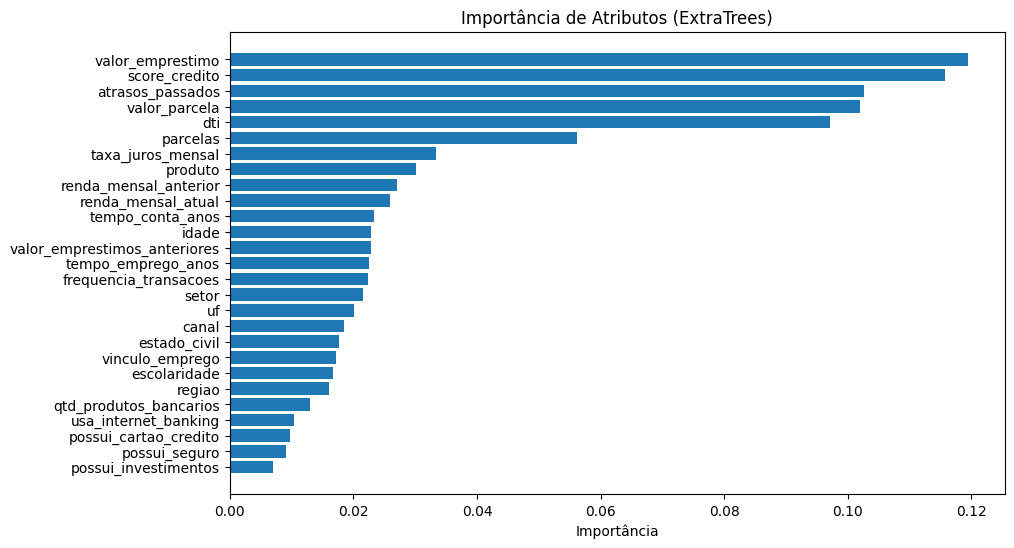

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier

target_col = "inadimplente"

# --- Seleção de features (numéricas, exceto alvo) ---
X = df_baseline_sem_nan.drop(columns=[target_col])
X = X.select_dtypes(include=[np.number])  # apenas colunas numéricas
y = df_baseline_sem_nan[target_col]

# --- Modelo ExtraTrees ---
modelo = ExtraTreesClassifier(n_estimators=200, random_state=42)
modelo.fit(X, y)

# --- Importâncias ---
importancias = modelo.feature_importances_

# Cria dataframe ordenado
df_importancias = pd.DataFrame({
    "Variavel": X.columns,
    "Importancia": importancias
}).sort_values(by="Importancia", ascending=False)

print("\nRanking de Importância de Variáveis:")
display(df_importancias)

# --- Plot ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(df_importancias["Variavel"], df_importancias["Importancia"])
plt.gca().invert_yaxis()  # maior no topo
plt.title("Importância de Atributos (ExtraTrees)")
plt.xlabel("Importância")
plt.show()


In [ ]:
# --- Nome da variável resposta ---
target_col = "inadimplente"

# 1) DataFrame só com as variáveis explicativas
df_baseline_sem_target = df_baseline_sem_nan.drop(columns=[target_col]).copy()

# 2) DataFrame com as variáveis explicativas + variável resposta
df_baseline_com_target = df_baseline_sem_nan.copy()

print("DataFrame apenas com as variáveis explicativas:")
display(df_baseline_sem_target)

print("\nDataFrame com as variáveis explicativas + variável resposta:")
display(df_baseline_com_target)

DataFrame apenas com as variáveis explicativas:


,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,vinculo_emprego,setor,...,atrasos_passados,score_credito,parcelas,valor_emprestimo,taxa_juros_mensal,valor_parcela,dti,frequencia_transacoes,valor_emprestimos_anteriores,tempo_emprego_anos
1,6,2,30,2.4,1,4,0,1,1,4,...,6,449,36,44847.64,0.0400,2371.85,0.114,21,15534.02,6.3
5,9,2,44,5.6,0,3,3,2,1,2,...,3,585,24,42626.56,0.0400,2795.74,0.225,9,26802.44,11.2
6,7,3,46,6.7,0,4,1,3,0,4,...,5,620,24,17433.05,0.0359,1095.89,0.196,11,19454.20,1.7
8,9,2,32,3.8,2,3,3,1,1,6,...,3,690,6,17448.36,0.0263,3181.54,0.072,13,1285.99,2.4
10,2,0,29,8.4,2,4,1,0,1,2,...,4,485,24,36911.00,0.0381,2374.01,0.195,29,9167.06,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999978,5,3,28,9.5,0,3,1,2,2,6,...,4,690,36,24160.89,0.0254,1032.03,0.291,16,6934.72,0.0
999981,6,2,44,2.7,3,2,1,0,3,3,...,6,483,60,26517.19,0.0317,993.31,0.050,16,2206.95,0.9
999987,8,3,40,3.0,0,3,1,1,4,1,...,3,485,12,6814.34,0.0400,726.08,0.012,15,25160.46,6.1
999992,8,3,41,2.9,2,2,3,2,1,3,...,0,871,120,28213.84,0.0147,501.85,0.048,20,25543.87,2.3



DataFrame com as variáveis explicativas + variável resposta:


,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,vinculo_emprego,setor,...,score_credito,parcelas,valor_emprestimo,taxa_juros_mensal,valor_parcela,dti,frequencia_transacoes,valor_emprestimos_anteriores,inadimplente,tempo_emprego_anos
1,6,2,30,2.4,1,4,0,1,1,4,...,449,36,44847.64,0.0400,2371.85,0.114,21,15534.02,1,6.3
5,9,2,44,5.6,0,3,3,2,1,2,...,585,24,42626.56,0.0400,2795.74,0.225,9,26802.44,0,11.2
6,7,3,46,6.7,0,4,1,3,0,4,...,620,24,17433.05,0.0359,1095.89,0.196,11,19454.20,0,1.7
8,9,2,32,3.8,2,3,3,1,1,6,...,690,6,17448.36,0.0263,3181.54,0.072,13,1285.99,0,2.4
10,2,0,29,8.4,2,4,1,0,1,2,...,485,24,36911.00,0.0381,2374.01,0.195,29,9167.06,0,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999978,5,3,28,9.5,0,3,1,2,2,6,...,690,36,24160.89,0.0254,1032.03,0.291,16,6934.72,0,0.0
999981,6,2,44,2.7,3,2,1,0,3,3,...,483,60,26517.19,0.0317,993.31,0.050,16,2206.95,0,0.9
999987,8,3,40,3.0,0,3,1,1,4,1,...,485,12,6814.34,0.0400,726.08,0.012,15,25160.46,0,6.1
999992,8,3,41,2.9,2,2,3,2,1,3,...,871,120,28213.84,0.0147,501.85,0.048,20,25543.87,0,2.3


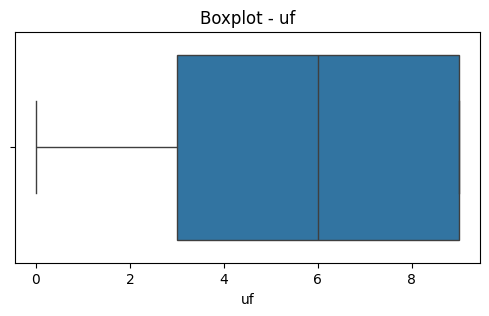

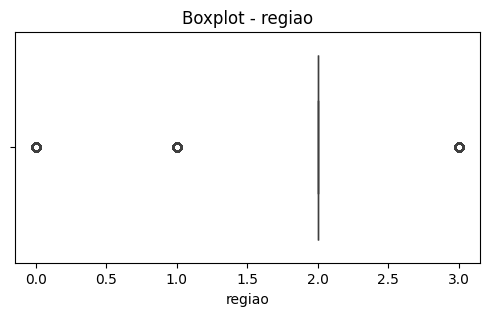

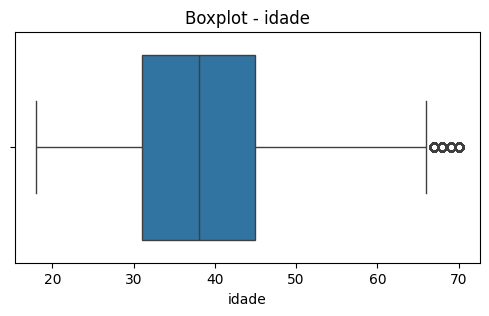

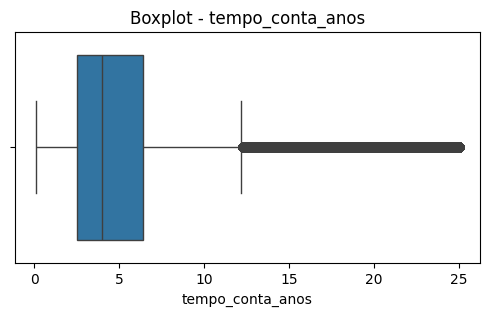

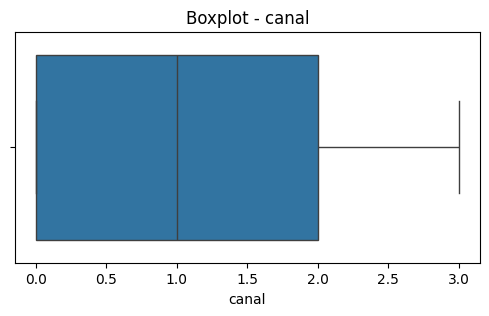

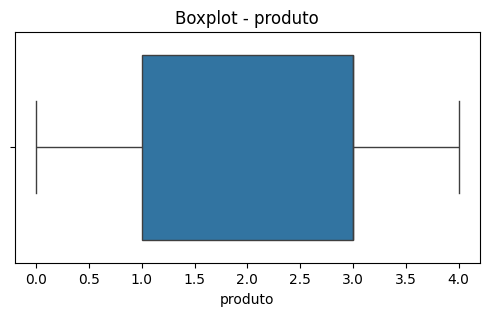

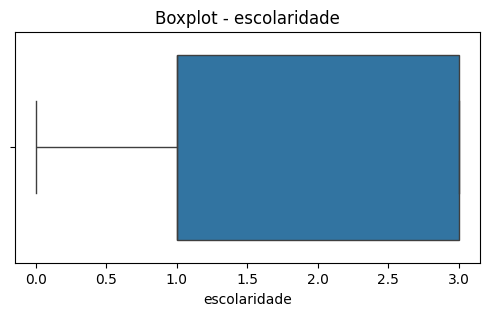

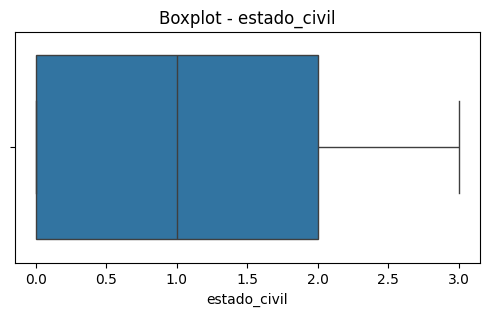

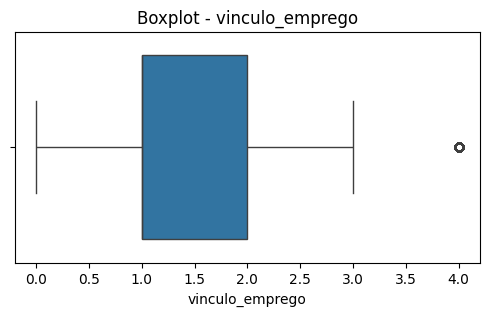

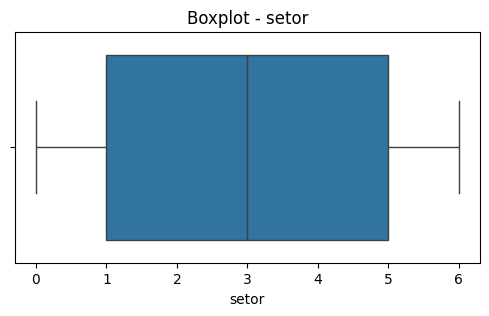

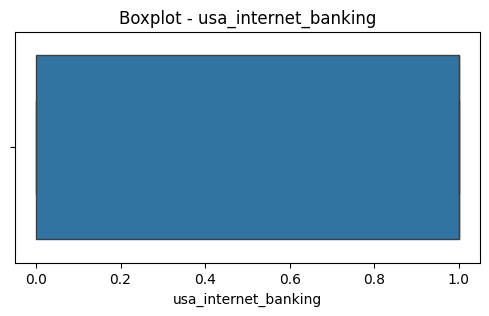

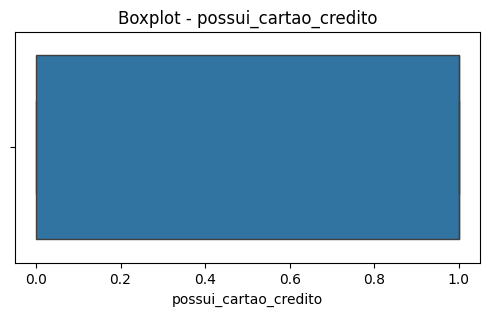

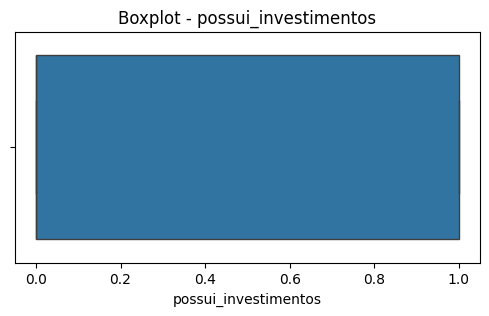

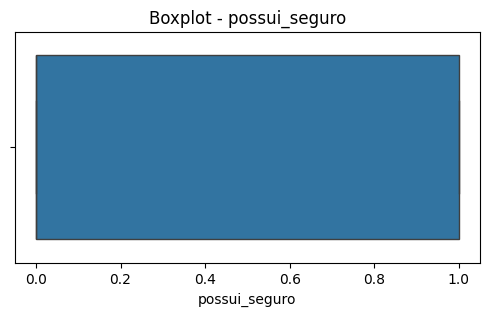

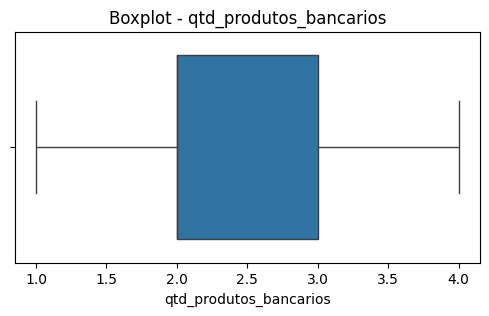

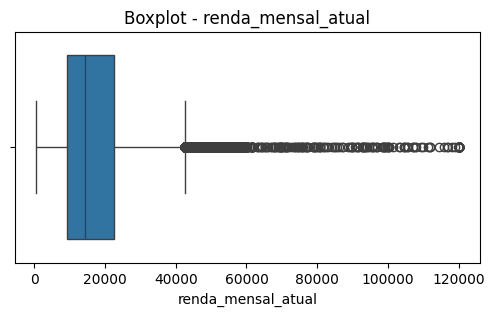

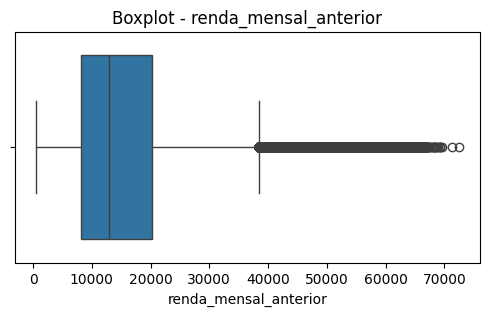

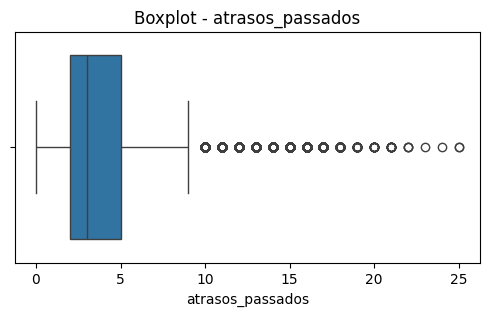

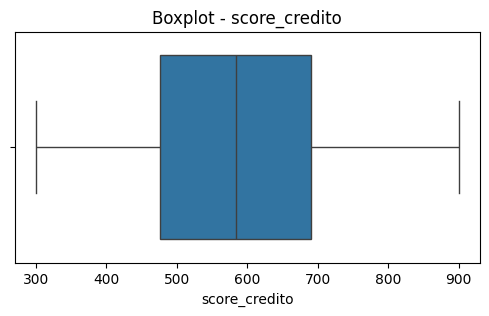

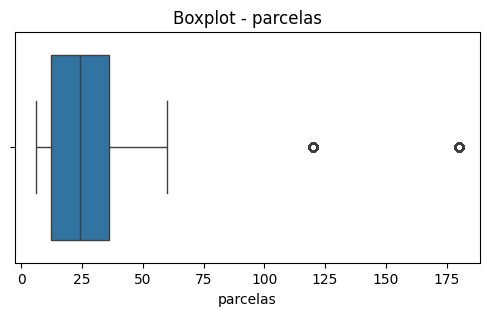

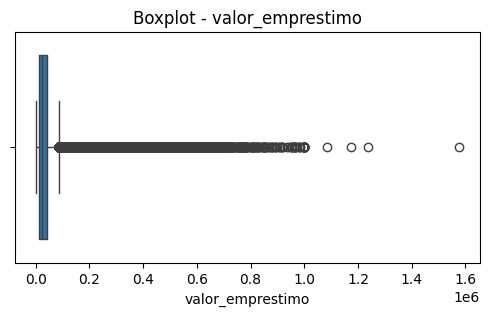

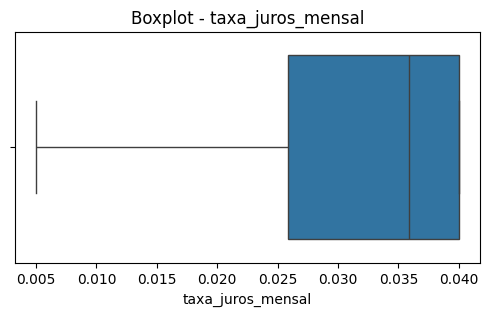

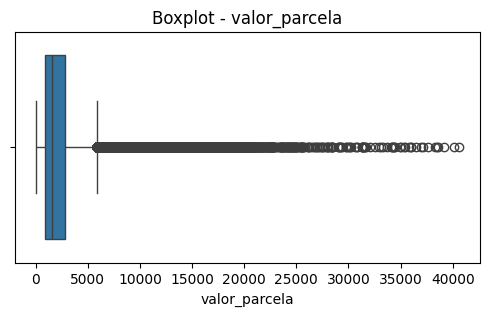

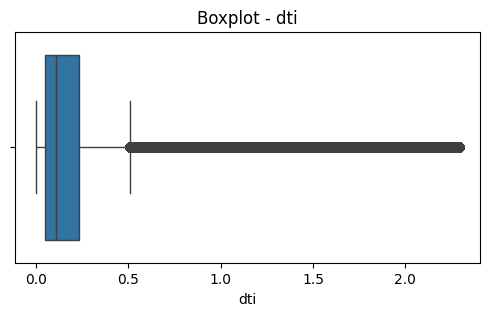

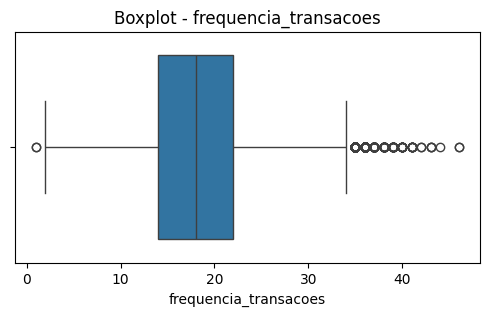

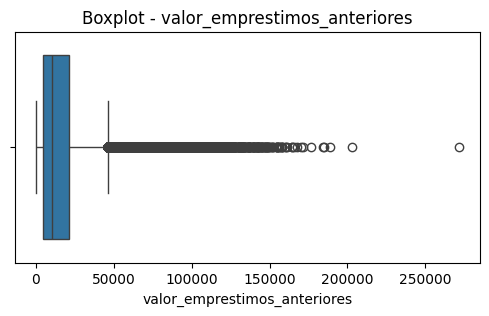

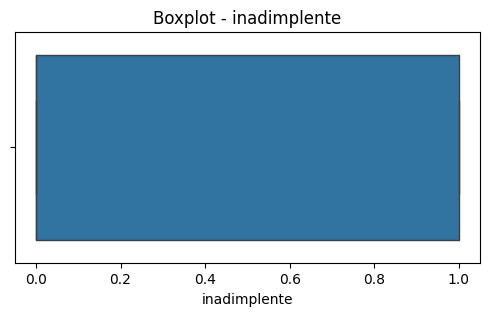

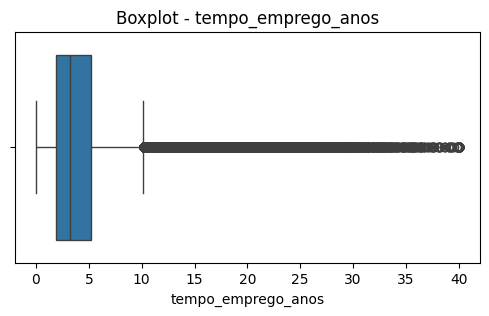

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot para cada variável numérica
for col in df_baseline_com_target.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df_baseline_com_target[col])
    plt.title(f"Boxplot - {col}")
    plt.show()


In [ ]:
import pandas as pd

def detectar_outliers_iqr(df, fator=1.5):
    """
    Detecta outliers em todas as colunas numéricas usando método IQR.

    Retorna:
      - lista_colunas: lista com nomes das colunas que possuem outliers
      - df_resumo: DataFrame com colunas [coluna, qtd_outliers, perc_outliers]
    """
    resultados = []
    colunas_com_outliers = []
    n_total = len(df)

    for col in df.select_dtypes(include="number").columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        limite_inferior = q1 - fator * iqr
        limite_superior = q3 + fator * iqr

        mask_outliers = (df[col] < limite_inferior) | (df[col] > limite_superior)
        qtd = mask_outliers.sum()

        if qtd > 0:
            colunas_com_outliers.append(col)
            resultados.append({
                "coluna": col,
                "qtd_outliers": qtd,
                "perc_outliers": round(qtd / n_total * 100, 2)
            })

    df_resumo = pd.DataFrame(resultados).sort_values(by="perc_outliers", ascending=False)
    return colunas_com_outliers, df_resumo


In [ ]:
cols_out, df_outliers = detectar_outliers_iqr(df_baseline_com_target)

print("Colunas com outliers:", cols_out)
display(df_outliers)

df_colunas_com_outliers_maior_5pct = df_outliers[df_outliers["perc_outliers"] >= 3]
colunas_com_outliers_maior_5pct = list(df_colunas_com_outliers_maior_5pct["coluna"])
colunas_com_outliers_maior_5pct


Colunas com outliers: ['regiao', 'idade', 'tempo_conta_anos', 'vinculo_emprego', 'renda_mensal_atual', 'renda_mensal_anterior', 'atrasos_passados', 'parcelas', 'valor_emprestimo', 'valor_parcela', 'dti', 'frequencia_transacoes', 'valor_emprestimos_anteriores', 'tempo_emprego_anos']


,coluna,qtd_outliers,perc_outliers
0,regiao,134825,39.93
3,vinculo_emprego,33637,9.96
10,dti,28501,8.44
9,valor_parcela,23536,6.97
8,valor_emprestimo,19776,5.86
2,tempo_conta_anos,18631,5.52
13,tempo_emprego_anos,17591,5.21
5,renda_mensal_anterior,17410,5.16
4,renda_mensal_atual,17404,5.15
12,valor_emprestimos_anteriores,17205,5.09


['regiao',
 'vinculo_emprego',
 'dti',
 'valor_parcela',
 'valor_emprestimo',
 'tempo_conta_anos',
 'tempo_emprego_anos',
 'renda_mensal_anterior',
 'renda_mensal_atual',
 'valor_emprestimos_anteriores',
 'atrasos_passados',
 'parcelas']

### 4 - Feature Enginnering

In [ ]:
!pip install optbinning

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from optbinning import OptimalBinning

def _auto_monotonic_trend(x, y):
    """Define monotonicidade automaticamente via correlação de Spearman (sinal)."""
    xr = pd.Series(x).rank(method="average")
    rho = pd.Series(xr).corr(pd.Series(y), method="spearman")
    if pd.isna(rho) or rho == 0:
        return None
    return "ascending" if rho > 0 else "descending"

def binarizar_com_optbinning_multi(
    df: pd.DataFrame,
    colunas: list,
    target: str = "inadimplente",
    max_n_bins: int = 10,
    min_bin_size: float = 0.05,          # fração mínima por bin (ex.: 0.05 = 5%)
    monotonic_trend: str | None | str = "auto",   # "auto", "ascending", "descending" ou None
    special_codes=None,                  # ex.: [np.nan]
    user_splits: dict | None = None,     # {coluna: [splits...]} opcional por coluna
    solver: str = "cp",
    metric_bins: str = "bins",           # "bins" (rótulo textual) ou "indices"
    plot: bool = True,                   # plota gráfico por coluna
    ignore_non_numeric: bool = True      # pula colunas não numéricas se True
):
    """
    Aplica binning ótimo 1D (OptBinning) para cada coluna em `colunas` com base em `target` binário (0/1).

    Retorna:
      - df_out:        df original + colunas 'bin_<col>'
      - bt_dict:       {coluna: binning_table_df}
      - meta_dict:     {coluna: {"monotonic_trend_used", "splits", "iv_total"}}
      - encoders_dict: {coluna: objeto OptimalBinning treinado} (para reuso em produção)
    """
    assert target in df.columns, f"Coluna target '{target}' não encontrada."

    df_out = df.copy()
    bt_dict = {}
    meta_dict = {}
    encoders_dict = {}

    # Garante que user_splits seja dict (pode ser None)
    if user_splits is None:
        user_splits = {}

    for coluna in colunas:
        if coluna not in df.columns:
            print(f"[Aviso] Coluna '{coluna}' não encontrada. Pulando.")
            continue

        # Se solicitado, ignora colunas não numéricas
        if ignore_non_numeric and (not pd.api.types.is_numeric_dtype(df[coluna])):
            print(f"[Aviso] '{coluna}' não é numérica. Pulando (ignore_non_numeric=True).")
            continue

        # Filtra amostra válida
        mask_valid = df[coluna].notna() & df[target].isin([0, 1])
        x = df.loc[mask_valid, coluna].astype(float).values
        y = df.loc[mask_valid, target].astype(int).values

        if x.size == 0:
            print(f"[Aviso] '{coluna}' não possui dados válidos com target em {{0,1}}. Pulando.")
            continue

        # Define monotonicidade
        mono = monotonic_trend
        if monotonic_trend == "auto":
            mono = _auto_monotonic_trend(x, y)

        # Instancia e treina
        optb = OptimalBinning(
            name=coluna,
            dtype="numerical",
            solver=solver,
            monotonic_trend=mono,
            max_n_bins=max_n_bins,
            min_bin_size=min_bin_size,
            special_codes=special_codes,
            user_splits=user_splits.get(coluna)  # permite splits específicos por coluna
        )
        optb.fit(x, y)

        # Tabela de bins
        bt = optb.binning_table
        bt_df = bt.build()

        # IV total (compatível com versões diferentes)
        try:
            iv_total = float(bt_df["IV"].sum())
        except Exception:
            iv_total = getattr(bt, "iv", np.nan)

        # Transform (labels textuais ou índices)
        bins_vals = optb.transform(x, metric=metric_bins)  # "bins" -> "(-inf, 1200]" | "indices" -> 0,1,2,...

        # Escreve no df_out
        bin_col = f"bin_{coluna}"
        df_out[bin_col] = pd.NA
        df_out.loc[mask_valid, bin_col] = bins_vals.astype(object)  # garante dtype capaz de texto/índice

        # Guarda saídas
        bt_dict[coluna] = bt_df
        meta_dict[coluna] = {
            "monotonic_trend_used": mono,
            "splits": getattr(optb, "splits", None),
            "iv_total": iv_total
        }
        encoders_dict[coluna] = optb

        # Plot simples por coluna
        if plot:
            aux = bt_df.copy()
            aux["Bin"] = aux["Bin"].astype(str)
            fig, ax1 = plt.subplots(figsize=(10, 4))
            sns.barplot(x="Bin", y="Event rate", data=aux, ax=ax1)
            ax1.set_ylabel("Event rate")
            ax1.set_xlabel("Bins")
            ax1.set_title(f"[{coluna}] Binning por '{target}' (monotonic: {mono})")
            ax1.tick_params(axis="x", rotation=45)

            ax2 = ax1.twinx()
            ax2.plot(aux["Bin"], aux["Count"], marker="o")
            ax2.set_ylabel("Count")
            plt.tight_layout()
            plt.show()

    # Informativos finais
    if not bt_dict:
        print("[Aviso] Nenhuma coluna foi processada. Verifique a lista ou tipos/target.")

    return df_out, bt_dict, meta_dict, encoders_dict


In [ ]:
colunas_para_binning = colunas_com_outliers_maior_5pct

df_bins, tabelas, metas, modelos = binarizar_com_optbinning_multi(
    df=df_baseline_com_target,
    colunas=colunas_para_binning,
    target="inadimplente",
    max_n_bins=10,
    min_bin_size=0.05,
    monotonic_trend="auto",          # usa Spearman para decidir
    special_codes=[np.nan],          # deixa o optbinning lidar com NaN
    user_splits=None,                # opcional
    solver="cp",
    metric_bins="bins",              # "bins" (texto) ou "indices"
    plot=False,
    ignore_non_numeric=True
)

# df_bins agora tem colunas: bin_renda, bin_saldo_devedor, bin_percentual_utilizacao
# tabelas["renda"] -> DataFrame com WOE/IV/Event rate etc.
# metas["renda"]["iv_total"] -> IV total da variável
# modelos["renda"] -> objeto OptimalBinning treinado (para reuso em produção)
display(df_bins)
display(tabelas)


c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\d

,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,vinculo_emprego,setor,...,bin_dti,bin_valor_parcela,bin_valor_emprestimo,bin_tempo_conta_anos,bin_tempo_emprego_anos,bin_renda_mensal_anterior,bin_renda_mensal_atual,bin_valor_emprestimos_anteriores,bin_atrasos_passados,bin_parcelas
1,6,2,30,2.4,1,4,0,1,1,4,...,"[0.08, 0.12)","[2362.12, 2797.86)","[34653.91, 46703.44)","[2.35, 3.45)","[3.25, 9.85)","[15285.65, 17679.05)","[17645.88, 21410.46)","[14689.00, 23597.21)","[5.50, 7.50)","[30.00, 42.00)"
5,9,2,44,5.6,0,3,3,2,1,2,...,"[0.19, 0.29)","[2362.12, 2797.86)","[34653.91, 46703.44)","[5.05, 6.35)","[9.85, inf)","[9985.92, 12626.35)","[11933.63, 13648.93)","[23597.21, inf)","[2.50, 3.50)","[21.00, 30.00)"
6,7,3,46,6.7,0,4,1,3,0,4,...,"[0.19, 0.29)","[1040.65, 1550.95)","[15909.70, 19795.43)","[6.35, 7.55)","[0.15, 3.25)","[5128.86, 7171.15)","(-inf, 5636.69)","[14689.00, 23597.21)","[4.50, 5.50)","[21.00, 30.00)"
8,9,2,32,3.8,2,3,3,1,1,6,...,"[0.06, 0.08)","[2797.86, 3815.92)","[15909.70, 19795.43)","[3.45, 4.05)","[0.15, 3.25)","[34182.38, inf)","[37125.03, inf)","(-inf, 5674.04)","[2.50, 3.50)","(-inf, 21.00)"
10,2,0,29,8.4,2,4,1,0,1,2,...,"[0.19, 0.29)","[2362.12, 2797.86)","[34653.91, 46703.44)","[7.55, 9.05)","[0.15, 3.25)","[9985.92, 12626.35)","[11933.63, 13648.93)","[5674.04, 12412.45)","[3.50, 4.50)","[21.00, 30.00)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999978,5,3,28,9.5,0,3,1,2,2,6,...,"[0.29, 0.42)","[811.88, 1040.65)","[19795.43, 25755.53)","[9.05, 11.45)","(-inf, 0.15)","(-inf, 5128.86)","(-inf, 5636.69)","[5674.04, 12412.45)","[3.50, 4.50)","[30.00, 42.00)"
999981,6,2,44,2.7,3,2,1,0,3,3,...,"[0.04, 0.06)","[811.88, 1040.65)","[25755.53, 34653.91)","[2.35, 3.45)","[0.15, 3.25)","[15285.65, 17679.05)","[17645.88, 21410.46)","(-inf, 5674.04)","[5.50, 7.50)","[54.00, inf)"
999987,8,3,40,3.0,0,3,1,1,4,1,...,"(-inf, 0.03)","[517.28, 811.88)","(-inf, 10752.14)","[2.35, 3.45)","[3.25, 9.85)","[34182.38, inf)","[37125.03, inf)","[23597.21, inf)","[2.50, 3.50)","(-inf, 21.00)"
999992,8,3,41,2.9,2,2,3,2,1,3,...,"[0.04, 0.06)","(-inf, 517.28)","[25755.53, 34653.91)","[2.35, 3.45)","[0.15, 3.25)","[7171.15, 9985.92)","[9021.66, 11933.63)","[23597.21, inf)","(-inf, 0.50)","[54.00, inf)"


{'regiao':                  Bin   Count  Count (%)  Non-event   Event  Event rate  \
 0       (-inf, 1.50)   67215   0.199043      44962   22253    0.331072   
 1       [1.50, 2.50)  202866   0.600744     137332   65534    0.323041   
 2        [2.50, inf)   67610   0.200213      45840   21770    0.321994   
 3            Special       0   0.000000          0       0    0.000000   
 4            Missing       0   0.000000          0       0    0.000000   
 Totals                337691   1.000000     228134  109557    0.324430   
 
              WoE        IV        JS  
 0      -0.030147  0.000182  0.000023  
 1       0.006344  0.000024  0.000003  
 2       0.011136  0.000025  0.000003  
 3            0.0  0.000000  0.000000  
 4            0.0  0.000000  0.000000  
 Totals            0.000231  0.000029  ,
 'vinculo_emprego':                  Bin   Count  Count (%)  Non-event   Event  Event rate  \
 0       (-inf, 0.50)   67238   0.199111      44357   22881    0.340299   
 1       [0.5

In [ ]:
import re
import numpy as np
import pandas as pd

_INTERVAL_RE = re.compile(
    r"^\s*([\[\(])\s*([-\w\.]+)\s*,\s*([-\w\.]+)\s*([\]\)])\s*$",
    flags=re.IGNORECASE
)

def _parse_endpoint(x: str) -> float:
    x = str(x).strip().lower()
    if x in ("-inf", "-infinity", "-∞"):
        return -np.inf
    if x in ("inf", "+inf", "infinity", "∞"):
        return np.inf
    return float(x)

def _bt_from_bin_strings(bt: pd.DataFrame) -> pd.DataFrame:
    """
    Converte uma binning table no formato com coluna 'Bin' textual para
    um DataFrame com colunas ['Bin', 'Lower bound', 'Upper bound'] apenas
    nas linhas de intervalo (descarta Totals/Special/Missing aqui).
    Retorna (somente intervalos).
    """
    rows = []
    for _, r in bt.iterrows():
        b = str(r.get("Bin", ""))
        if b.lower() in ("totals",):
            continue
        if b.lower() in ("special", "missing"):
            # Não vira intervalo; tratado fora.
            continue
        m = _INTERVAL_RE.match(b)
        if not m:
            # Linha que não é intervalo reconhecível → ignora
            continue
        left_br, lb_txt, ub_txt, right_br = m.groups()
        lb = _parse_endpoint(lb_txt)
        ub = _parse_endpoint(ub_txt)
        # Guardamos o rótulo original (Bin) como label textual
        rows.append({"Bin": b, "Lower bound": lb, "Upper bound": ub})
    if not rows:
        return pd.DataFrame(columns=["Bin", "Lower bound", "Upper bound"])
    out = pd.DataFrame(rows)

    # Ordena por limites e garante contiguidade (assumida)
    order = np.lexsort((out["Upper bound"].to_numpy(), out["Lower bound"].to_numpy()))
    out = out.iloc[order].reset_index(drop=True)
    return out

def aplicar_bins_por_tabelas(
    df: pd.DataFrame,
    bt_dict: dict,
    colunas: list | None = None,
    prefixo: str = "bin_",
    saida: str = "labels",            # "labels" ou "indices"
    ignore_non_numeric: bool = True,
    special_codes_map: dict | None = None  # ex.: {"renda": [0, -1, np.nan], "saldo": [999999999]}
):
    """
    Aplica bins conforme tabelas em bt_dict.
    Aceita:
      1) Tabelas com ["Lower bound","Upper bound","Bin"] (padrão)
      2) Tabelas com ["Bin"] textual nos moldes '(-inf, 1.50)', '[1.50, 2.50)', etc.,
         com linhas 'Special' e 'Missing'.
    Assume intervalos CONTÍGUOS e aplica a convenção (lb, ub] (right=True).
    """
    df_out = df.copy()
    info = {}

    if colunas is None:
        colunas = [c for c in bt_dict.keys() if c in df_out.columns]

    for col in colunas:
        if col not in df_out.columns:
            print(f"[Aviso] '{col}' não está no DataFrame. Pulando.")
            continue
        if ignore_non_numeric and (not pd.api.types.is_numeric_dtype(df_out[col])):
            print(f"[Aviso] '{col}' não é numérica. Pulando (ignore_non_numeric=True).")
            continue

        raw_bt = bt_dict.get(col)
        if raw_bt is None or "Bin" not in raw_bt.columns:
            print(f"[Aviso] Tabela de bins inválida para '{col}'. Pulando.")
            continue

        # Detecta rótulos de Special/Missing (se existirem)
        label_special = None
        label_missing = None
        if "Bin" in raw_bt.columns:
            if (raw_bt["Bin"].astype(str).str.lower() == "special").any():
                label_special = "Special"
            if (raw_bt["Bin"].astype(str).str.lower() == "missing").any():
                label_missing = "Missing"

        # Normaliza para formato com limites
        if {"Lower bound", "Upper bound"}.issubset(raw_bt.columns):
            btf = raw_bt.loc[:, ["Bin", "Lower bound", "Upper bound"]].copy()
            # remove linhas sem limites (ex.: Special/Missing/Totals)
            btf = btf[btf["Lower bound"].notna() | btf["Upper bound"].notna()].copy()
        else:
            btf = _bt_from_bin_strings(raw_bt)

        if btf.empty:
            print(f"[Aviso] Nenhum intervalo encontrado para '{col}'. Pulando.")
            continue

        lbs = btf["Lower bound"].to_numpy()
        ubs = btf["Upper bound"].to_numpy()

        lbs = np.where(pd.isna(lbs), -np.inf, lbs.astype(float))
        ubs = np.where(pd.isna(ubs),  np.inf,  ubs.astype(float))

        # Ordena
        order = np.lexsort((ubs, lbs))
        lbs = lbs[order]
        ubs = ubs[order]
        labels = btf["Bin"].astype(str).to_numpy()[order]

        # edges para pd.cut com right=True => (lb, ub]
        edges = [lbs[0]] + list(ubs)

        s = df_out[col].astype(float)
        binned = pd.cut(s, bins=edges, labels=labels, right=True, include_lowest=False)

        # Missing: valores NaN no dado → rotula como 'Missing' se existir
        if label_missing is not None:
            is_nan = s.isna()
            if is_nan.any():
                binned = binned.astype(object)
                binned[is_nan] = label_missing

        # Special: valores explícitos fornecidos no special_codes_map → rotula 'Special'
        if special_codes_map and col in special_codes_map and label_special is not None:
            vals_special = special_codes_map[col]
            is_special = s.isin(vals_special)
            if is_special.any():
                binned = binned.astype(object)
                binned[is_special] = label_special

        out_col = f"{prefixo}{col}"
        if saida == "labels":
            df_out[out_col] = binned.astype("object")
        elif saida == "indices":
            cat = pd.Categorical(binned, categories=list(labels), ordered=True)
            # Observação: 'Missing'/'Special' (se usados) não estão em 'labels' -> viram -1
            df_out[out_col] = cat.codes.astype("int32")
        else:
            raise ValueError("Parâmetro 'saida' deve ser 'labels' ou 'indices'.")

        info[col] = {"labels": list(labels), "edges": edges}

    return df_out, info


In [ ]:
# Supondo que você já tenha bt_dict vindo do seu binarizar_com_optbinning_multi(...)
# e quer aplicar as mesmas faixas em um novo df (ex.: df_validacao):

df_val_binado, info_bins = aplicar_bins_por_tabelas(
    df=df_monitoramento_encoded,
    bt_dict=tabelas,
    colunas=list(tabelas.keys()),  # ou uma sublista
    prefixo="bin_",
    saida="labels",                 # ou "indices"
    ignore_non_numeric=True,
    special_codes_map=None          # ou {"renda": [0, -1, np.nan]}
)

display(df_val_binado)
display(df_val_binado.columns)

df_monitoramento_encoded_binado = df_val_binado
display(df_monitoramento_encoded_binado)
display(df_monitoramento_encoded_binado["bin_tempo_emprego_anos"].value_counts())


# Agora df_val_binado contém colunas como bin_renda, bin_saldo_devedor, ...


,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,vinculo_emprego,setor,...,bin_dti,bin_valor_parcela,bin_valor_emprestimo,bin_tempo_conta_anos,bin_tempo_emprego_anos,bin_renda_mensal_anterior,bin_renda_mensal_atual,bin_valor_emprestimos_anteriores,bin_atrasos_passados,bin_parcelas
4,4,1,35,3.0,3,4,2,0,0,4,...,"[0.08, 0.12)","[2797.86, 3815.92)","[56383.24, 69977.16)","[2.35, 3.45)","[3.25, 9.85)","[34182.38, inf)","[37125.03, inf)","[5674.04, 12412.45)","[7.50, inf)","[30.00, 42.00)"
12,9,2,38,2.3,0,1,0,2,4,1,...,"[0.12, 0.19)","[1550.95, 1884.55)","[15909.70, 19795.43)","[1.35, 2.35)","[9.85, inf)","[7171.15, 9985.92)","[9021.66, 11933.63)","[23597.21, inf)","[0.50, 1.50)","(-inf, 21.00)"
18,8,3,29,4.8,0,1,3,2,2,3,...,"[0.04, 0.06)","(-inf, 517.28)","(-inf, 10752.14)","[4.05, 5.05)","(-inf, 0.15)","(-inf, 5128.86)","(-inf, 5636.69)","[23597.21, inf)","[5.50, 7.50)","[42.00, 54.00)"
28,2,0,49,24.4,1,3,0,0,0,2,...,"[0.12, 0.19)","[517.28, 811.88)","(-inf, 10752.14)","[11.45, inf)","[3.25, 9.85)","[5128.86, 7171.15)","[5636.69, 7381.37)","[23597.21, inf)","[7.50, inf)","(-inf, 21.00)"
31,3,2,36,25.0,1,3,2,2,0,6,...,"[0.66, inf)","[2797.86, 3815.92)","[46703.44, 56383.24)","[11.45, inf)","[0.15, 3.25)","(-inf, 5128.86)","(-inf, 5636.69)","(-inf, 5674.04)","[1.50, 2.50)","(-inf, 21.00)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999986,4,1,41,6.9,1,4,2,1,0,4,...,"[0.06, 0.08)","[1040.65, 1550.95)","[25755.53, 34653.91)","[6.35, 7.55)","[0.15, 3.25)","[17679.05, 21293.55)","[21410.46, 27792.28)","(-inf, 5674.04)","(-inf, 0.50)","[21.00, 30.00)"
999993,6,2,38,8.3,0,4,2,0,1,6,...,"[0.06, 0.08)","[1550.95, 1884.55)","[34653.91, 46703.44)","[7.55, 9.05)","[3.25, 9.85)","[17679.05, 21293.55)","[17645.88, 21410.46)","[14689.00, 23597.21)","[2.50, 3.50)","[54.00, inf)"
999996,6,2,55,7.0,3,1,0,0,1,0,...,"[0.29, 0.42)","[1550.95, 1884.55)","[15909.70, 19795.43)","[6.35, 7.55)","[3.25, 9.85)","(-inf, 5128.86)","(-inf, 5636.69)","(-inf, 5674.04)","[1.50, 2.50)","(-inf, 21.00)"
999997,0,1,24,1.5,3,1,2,0,1,3,...,"[0.06, 0.08)","[1884.55, 2362.12)","[69977.16, 95803.96)","[1.35, 2.35)","[3.25, 9.85)","[28089.74, 34182.38)","[27792.28, 37125.03)","(-inf, 5674.04)","[0.50, 1.50)","[54.00, inf)"


Index(['uf', 'regiao', 'idade', 'tempo_conta_anos', 'canal', 'produto',
       'escolaridade', 'estado_civil', 'vinculo_emprego', 'setor',
       'usa_internet_banking', 'possui_cartao_credito', 'possui_investimentos',
       'possui_seguro', 'qtd_produtos_bancarios', 'renda_mensal_atual',
       'renda_mensal_anterior', 'atrasos_passados', 'score_credito',
       'parcelas', 'valor_emprestimo', 'taxa_juros_mensal', 'valor_parcela',
       'dti', 'frequencia_transacoes', 'valor_emprestimos_anteriores',
       'inadimplente', 'tempo_emprego_anos', 'bin_regiao',
       'bin_vinculo_emprego', 'bin_dti', 'bin_valor_parcela',
       'bin_valor_emprestimo', 'bin_tempo_conta_anos',
       'bin_tempo_emprego_anos', 'bin_renda_mensal_anterior',
       'bin_renda_mensal_atual', 'bin_valor_emprestimos_anteriores',
       'bin_atrasos_passados', 'bin_parcelas'],
      dtype='object')

,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,vinculo_emprego,setor,...,bin_dti,bin_valor_parcela,bin_valor_emprestimo,bin_tempo_conta_anos,bin_tempo_emprego_anos,bin_renda_mensal_anterior,bin_renda_mensal_atual,bin_valor_emprestimos_anteriores,bin_atrasos_passados,bin_parcelas
4,4,1,35,3.0,3,4,2,0,0,4,...,"[0.08, 0.12)","[2797.86, 3815.92)","[56383.24, 69977.16)","[2.35, 3.45)","[3.25, 9.85)","[34182.38, inf)","[37125.03, inf)","[5674.04, 12412.45)","[7.50, inf)","[30.00, 42.00)"
12,9,2,38,2.3,0,1,0,2,4,1,...,"[0.12, 0.19)","[1550.95, 1884.55)","[15909.70, 19795.43)","[1.35, 2.35)","[9.85, inf)","[7171.15, 9985.92)","[9021.66, 11933.63)","[23597.21, inf)","[0.50, 1.50)","(-inf, 21.00)"
18,8,3,29,4.8,0,1,3,2,2,3,...,"[0.04, 0.06)","(-inf, 517.28)","(-inf, 10752.14)","[4.05, 5.05)","(-inf, 0.15)","(-inf, 5128.86)","(-inf, 5636.69)","[23597.21, inf)","[5.50, 7.50)","[42.00, 54.00)"
28,2,0,49,24.4,1,3,0,0,0,2,...,"[0.12, 0.19)","[517.28, 811.88)","(-inf, 10752.14)","[11.45, inf)","[3.25, 9.85)","[5128.86, 7171.15)","[5636.69, 7381.37)","[23597.21, inf)","[7.50, inf)","(-inf, 21.00)"
31,3,2,36,25.0,1,3,2,2,0,6,...,"[0.66, inf)","[2797.86, 3815.92)","[46703.44, 56383.24)","[11.45, inf)","[0.15, 3.25)","(-inf, 5128.86)","(-inf, 5636.69)","(-inf, 5674.04)","[1.50, 2.50)","(-inf, 21.00)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999986,4,1,41,6.9,1,4,2,1,0,4,...,"[0.06, 0.08)","[1040.65, 1550.95)","[25755.53, 34653.91)","[6.35, 7.55)","[0.15, 3.25)","[17679.05, 21293.55)","[21410.46, 27792.28)","(-inf, 5674.04)","(-inf, 0.50)","[21.00, 30.00)"
999993,6,2,38,8.3,0,4,2,0,1,6,...,"[0.06, 0.08)","[1550.95, 1884.55)","[34653.91, 46703.44)","[7.55, 9.05)","[3.25, 9.85)","[17679.05, 21293.55)","[17645.88, 21410.46)","[14689.00, 23597.21)","[2.50, 3.50)","[54.00, inf)"
999996,6,2,55,7.0,3,1,0,0,1,0,...,"[0.29, 0.42)","[1550.95, 1884.55)","[15909.70, 19795.43)","[6.35, 7.55)","[3.25, 9.85)","(-inf, 5128.86)","(-inf, 5636.69)","(-inf, 5674.04)","[1.50, 2.50)","(-inf, 21.00)"
999997,0,1,24,1.5,3,1,2,0,1,3,...,"[0.06, 0.08)","[1884.55, 2362.12)","[69977.16, 95803.96)","[1.35, 2.35)","[3.25, 9.85)","[28089.74, 34182.38)","[27792.28, 37125.03)","(-inf, 5674.04)","[0.50, 1.50)","[54.00, inf)"


bin_tempo_emprego_anos
[0.15, 3.25)    99383
[3.25, 9.85)    92439
[9.85, inf)     12131
(-inf, 0.15)    10834
Missing          8063
Name: count, dtype: int64

In [ ]:
display(df_bins.columns)
df_bins.dtypes
display(df_bins["bin_tempo_emprego_anos"].value_counts())

Index(['uf', 'regiao', 'idade', 'tempo_conta_anos', 'canal', 'produto',
       'escolaridade', 'estado_civil', 'vinculo_emprego', 'setor',
       'usa_internet_banking', 'possui_cartao_credito', 'possui_investimentos',
       'possui_seguro', 'qtd_produtos_bancarios', 'renda_mensal_atual',
       'renda_mensal_anterior', 'atrasos_passados', 'score_credito',
       'parcelas', 'valor_emprestimo', 'taxa_juros_mensal', 'valor_parcela',
       'dti', 'frequencia_transacoes', 'valor_emprestimos_anteriores',
       'inadimplente', 'tempo_emprego_anos', 'bin_regiao',
       'bin_vinculo_emprego', 'bin_dti', 'bin_valor_parcela',
       'bin_valor_emprestimo', 'bin_tempo_conta_anos',
       'bin_tempo_emprego_anos', 'bin_renda_mensal_anterior',
       'bin_renda_mensal_atual', 'bin_valor_emprestimos_anteriores',
       'bin_atrasos_passados', 'bin_parcelas'],
      dtype='object')

bin_tempo_emprego_anos
[0.15, 3.25)    156348
[3.25, 9.85)    145019
[9.85, inf)      19196
(-inf, 0.15)     17128
Name: count, dtype: int64

In [ ]:
import pandas as pd

def comparar_distintos(
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    colunas: list[str],
    considerar_na_como_valor: bool = True,
    token_na: str = "<NA>"
) -> tuple[pd.DataFrame, bool]:
    """
    Compara, para cada coluna em `colunas`, se o conjunto de valores distintos é igual entre df1 e df2.
    - A contagem/frequência NÃO importa.
    - Por padrão, NaN/None é tratado como um valor especial e comparado.

    Retorna:
      (resultado_df, todas_iguais)
      onde resultado_df tem:
        - coluna
        - iguais (bool)
        - so_no_df1 (lista dos valores que só aparecem no df1)
        - so_no_df2 (lista dos valores que só aparecem no df2)
    """
    def _distinct_set(sr: pd.Series) -> set:
        if considerar_na_como_valor:
            has_na = sr.isna().any()
            vals = set(sr.dropna().unique().tolist())
            if has_na:
                vals.add(token_na)
            return vals
        # sem normalização de NaN: remove NaN da comparação para evitar NaN != NaN
        return set(sr.dropna().unique().tolist())

    resultados = []
    for col in colunas:
        if col not in df1.columns or col not in df2.columns:
            resultados.append({
                "coluna": col,
                "iguais": False,
                "so_no_df1": None if col in df1.columns else "<coluna ausente no df1>",
                "so_no_df2": None if col in df2.columns else "<coluna ausente no df2>",
            })
            continue

        s1 = _distinct_set(df1[col])
        s2 = _distinct_set(df2[col])

        only1 = sorted(s1 - s2, key=lambda x: (str(type(x)), str(x)))
        only2 = sorted(s2 - s1, key=lambda x: (str(type(x)), str(x)))

        resultados.append({
            "coluna": col,
            "iguais": len(only1) == 0 and len(only2) == 0,
            "so_no_df1": only1,
            "so_no_df2": only2,
        })

    out = pd.DataFrame(resultados)
    return out, bool(out["iguais"].all())


In [ ]:
cols = ['bin_regiao',
       'bin_vinculo_emprego', 'bin_dti', 'bin_valor_parcela',
       'bin_valor_emprestimo', 'bin_tempo_conta_anos',
       'bin_tempo_emprego_anos', 'bin_renda_mensal_anterior',
       'bin_renda_mensal_atual', 'bin_valor_emprestimos_anteriores',
       'bin_atrasos_passados', 'bin_parcelas']

tabela, todas_iguais = comparar_distintos(
    df1=df_bins,
    df2=df_monitoramento_encoded_binado,
    colunas=cols
)

print(tabela)        # tabela com diferenças por coluna
print(todas_iguais)  # True se todas as colunas têm os mesmos valores distintos


                              coluna  iguais so_no_df1  so_no_df2
0                         bin_regiao    True        []         []
1                bin_vinculo_emprego    True        []         []
2                            bin_dti    True        []         []
3                  bin_valor_parcela    True        []         []
4               bin_valor_emprestimo    True        []         []
5               bin_tempo_conta_anos    True        []         []
6             bin_tempo_emprego_anos   False        []  [Missing]
7          bin_renda_mensal_anterior   False        []  [Missing]
8             bin_renda_mensal_atual   False        []  [Missing]
9   bin_valor_emprestimos_anteriores   False        []  [Missing]
10              bin_atrasos_passados    True        []         []
11                      bin_parcelas    True        []         []
False


In [ ]:
# Filtra só as linhas com algum NaN
linhas_missing = df_monitoramento_encoded_binado[df_monitoramento_encoded_binado.isna().any(axis=1)]
display(linhas_missing)

,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,vinculo_emprego,setor,...,bin_dti,bin_valor_parcela,bin_valor_emprestimo,bin_tempo_conta_anos,bin_tempo_emprego_anos,bin_renda_mensal_anterior,bin_renda_mensal_atual,bin_valor_emprestimos_anteriores,bin_atrasos_passados,bin_parcelas
38,8,3,41,2.8,1,3,1,0,0,0,...,"[0.06, 0.08)","[517.28, 811.88)","(-inf, 10752.14)","[2.35, 3.45)",Missing,"[7171.15, 9985.92)","[9021.66, 11933.63)","[23597.21, inf)","[1.50, 2.50)","(-inf, 21.00)"
47,8,3,35,6.0,3,0,1,2,1,4,...,"(-inf, 0.03)","(-inf, 517.28)","(-inf, 10752.14)","[5.05, 6.35)",Missing,"[34182.38, inf)","[37125.03, inf)","[5674.04, 12412.45)","[7.50, inf)","[21.00, 30.00)"
126,9,2,32,2.6,0,3,1,0,1,3,...,"[0.04, 0.06)","[1040.65, 1550.95)","[15909.70, 19795.43)","[2.35, 3.45)","[3.25, 9.85)","[17679.05, 21293.55)","[17645.88, 21410.46)",Missing,"[2.50, 3.50)","(-inf, 21.00)"
130,3,2,38,5.7,2,4,1,2,1,6,...,"[0.04, 0.06)","[1040.65, 1550.95)","[34653.91, 46703.44)","[5.05, 6.35)",Missing,"[21293.55, 28089.74)","[21410.46, 27792.28)","[5674.04, 12412.45)","[1.50, 2.50)","[54.00, inf)"
139,9,2,43,3.2,0,3,2,1,1,6,...,"[0.06, 0.08)","[1040.65, 1550.95)","[25755.53, 34653.91)","[2.35, 3.45)","[0.15, 3.25)",Missing,Missing,Missing,"[1.50, 2.50)","[30.00, 42.00)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999831,3,2,30,2.9,1,3,1,0,1,1,...,"[0.19, 0.29)","[2362.12, 2797.86)","[46703.44, 56383.24)","[2.35, 3.45)","[3.25, 9.85)",Missing,"[9021.66, 11933.63)","[5674.04, 12412.45)","[2.50, 3.50)","[30.00, 42.00)"
999850,3,2,48,7.0,3,3,1,0,4,5,...,"[0.06, 0.08)","[1550.95, 1884.55)","(-inf, 10752.14)","[6.35, 7.55)","[9.85, inf)","[21293.55, 28089.74)",Missing,"[5674.04, 12412.45)","[2.50, 3.50)","(-inf, 21.00)"
999898,9,2,42,2.5,1,0,0,1,3,5,...,"[0.08, 0.12)","[1040.65, 1550.95)","(-inf, 10752.14)","[2.35, 3.45)","[3.25, 9.85)",Missing,"[11933.63, 13648.93)","(-inf, 5674.04)","[5.50, 7.50)","(-inf, 21.00)"
999922,2,0,29,22.5,3,0,1,2,1,3,...,"[0.42, 0.66)","[2797.86, 3815.92)","[15909.70, 19795.43)","[11.45, inf)","[9.85, inf)","[5128.86, 7171.15)","(-inf, 5636.69)",Missing,"[2.50, 3.50)","(-inf, 21.00)"


In [ ]:
df_bins["tag_etapa_modelagem"] = "baseline"
df_monitoramento_encoded_binado["tag_etapa_modelagem"] = "monitoramento"

print("Baseline")
display(df_bins["tag_etapa_modelagem"].value_counts())
print("Monitoramento")
display(df_monitoramento_encoded_binado["tag_etapa_modelagem"].value_counts())

Baseline


tag_etapa_modelagem
baseline    337691
Name: count, dtype: int64

Monitoramento


tag_etapa_modelagem
monitoramento    222850
Name: count, dtype: int64

In [ ]:
import pandas as pd

def append_se_mesmas_colunas(df1: pd.DataFrame, df2: pd.DataFrame) -> pd.DataFrame:
    # pega as colunas de cada dataframe
    cols1 = set(df1.columns)
    cols2 = set(df2.columns)

    if cols1 != cols2:
        raise ValueError(f"As tabelas não têm as mesmas colunas.\n"
                         f"No df1 e não no df2: {cols1 - cols2}\n"
                         f"No df2 e não no df1: {cols2 - cols1}")

    # se passar na verificação, concatena
    return pd.concat([df1, df2], ignore_index=True)

df_unificado = append_se_mesmas_colunas(df_bins, df_monitoramento_encoded_binado)
display(df_unificado)

,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,vinculo_emprego,setor,...,bin_valor_parcela,bin_valor_emprestimo,bin_tempo_conta_anos,bin_tempo_emprego_anos,bin_renda_mensal_anterior,bin_renda_mensal_atual,bin_valor_emprestimos_anteriores,bin_atrasos_passados,bin_parcelas,tag_etapa_modelagem
0,6,2,30,2.4,1,4,0,1,1,4,...,"[2362.12, 2797.86)","[34653.91, 46703.44)","[2.35, 3.45)","[3.25, 9.85)","[15285.65, 17679.05)","[17645.88, 21410.46)","[14689.00, 23597.21)","[5.50, 7.50)","[30.00, 42.00)",baseline
1,9,2,44,5.6,0,3,3,2,1,2,...,"[2362.12, 2797.86)","[34653.91, 46703.44)","[5.05, 6.35)","[9.85, inf)","[9985.92, 12626.35)","[11933.63, 13648.93)","[23597.21, inf)","[2.50, 3.50)","[21.00, 30.00)",baseline
2,7,3,46,6.7,0,4,1,3,0,4,...,"[1040.65, 1550.95)","[15909.70, 19795.43)","[6.35, 7.55)","[0.15, 3.25)","[5128.86, 7171.15)","(-inf, 5636.69)","[14689.00, 23597.21)","[4.50, 5.50)","[21.00, 30.00)",baseline
3,9,2,32,3.8,2,3,3,1,1,6,...,"[2797.86, 3815.92)","[15909.70, 19795.43)","[3.45, 4.05)","[0.15, 3.25)","[34182.38, inf)","[37125.03, inf)","(-inf, 5674.04)","[2.50, 3.50)","(-inf, 21.00)",baseline
4,2,0,29,8.4,2,4,1,0,1,2,...,"[2362.12, 2797.86)","[34653.91, 46703.44)","[7.55, 9.05)","[0.15, 3.25)","[9985.92, 12626.35)","[11933.63, 13648.93)","[5674.04, 12412.45)","[3.50, 4.50)","[21.00, 30.00)",baseline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560536,4,1,41,6.9,1,4,2,1,0,4,...,"[1040.65, 1550.95)","[25755.53, 34653.91)","[6.35, 7.55)","[0.15, 3.25)","[17679.05, 21293.55)","[21410.46, 27792.28)","(-inf, 5674.04)","(-inf, 0.50)","[21.00, 30.00)",monitoramento
560537,6,2,38,8.3,0,4,2,0,1,6,...,"[1550.95, 1884.55)","[34653.91, 46703.44)","[7.55, 9.05)","[3.25, 9.85)","[17679.05, 21293.55)","[17645.88, 21410.46)","[14689.00, 23597.21)","[2.50, 3.50)","[54.00, inf)",monitoramento
560538,6,2,55,7.0,3,1,0,0,1,0,...,"[1550.95, 1884.55)","[15909.70, 19795.43)","[6.35, 7.55)","[3.25, 9.85)","(-inf, 5128.86)","(-inf, 5636.69)","(-inf, 5674.04)","[1.50, 2.50)","(-inf, 21.00)",monitoramento
560539,0,1,24,1.5,3,1,2,0,1,3,...,"[1884.55, 2362.12)","[69977.16, 95803.96)","[1.35, 2.35)","[3.25, 9.85)","[28089.74, 34182.38)","[27792.28, 37125.03)","(-inf, 5674.04)","[0.50, 1.50)","[54.00, inf)",monitoramento


In [ ]:
df_val_binado.dtypes

uf                                    int32
regiao                                int32
idade                                 int64
tempo_conta_anos                    float64
canal                                 int32
produto                               int32
escolaridade                          int32
estado_civil                          int32
vinculo_emprego                       int32
setor                                 int32
usa_internet_banking                  int32
possui_cartao_credito                 int32
possui_investimentos                  int32
possui_seguro                         int32
qtd_produtos_bancarios                int64
renda_mensal_atual                  float64
renda_mensal_anterior               float64
atrasos_passados                      int64
score_credito                         int64
parcelas                              int64
valor_emprestimo                    float64
taxa_juros_mensal                   float64
valor_parcela                   

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def aplicar_label_encoding(df: pd.DataFrame):
    """
    Aplica Label Encoding em todas as colunas categóricas e booleanas de um DataFrame.

    Retorna:
      - df_label: DataFrame com as colunas transformadas
      - le_dict:  dicionário {coluna: LabelEncoder treinado}
      - df_sem_nan: DataFrame sem valores NaN
    """
    # Identificar colunas categóricas e booleanas
    cat_cols  = df.select_dtypes(include=['object', 'category']).columns
    bool_cols = df.select_dtypes(include=['bool']).columns

    # Criar cópia do DataFrame
    df_label = df.copy()

    # Aplicar Label Encoding
    le_dict = {}
    for col in list(cat_cols) + list(bool_cols):
        le = LabelEncoder()
        df_label[col] = le.fit_transform(df_label[col].astype(str))  # converte p/ string p/ evitar erro com NaN
        le_dict[col] = le

    # Contagem de NaN
    qtd_linhas_nan = df_label.isna().any(axis=1).sum()
    qtd_sem_nan = df_label.notna().all(axis=1).sum()

    print("Quantidade de linhas com NaN:", qtd_linhas_nan)
    print("Quantidade de linhas sem NaN:", qtd_sem_nan)

    # DataFrame sem NaN
    df_sem_nan = df_label[df_label.notna().all(axis=1)]

    return df_label, le_dict, df_sem_nan


In [ ]:
df_label_bins, le_dict, df_sem_nan = aplicar_label_encoding(df_unificado)

display(df_label_bins.dtypes)
display(df_label_bins)
display(le_dict)

Quantidade de linhas com NaN: 29393
Quantidade de linhas sem NaN: 531148


uf                                    int64
regiao                                int64
idade                                 int64
tempo_conta_anos                    float64
canal                                 int64
produto                               int64
escolaridade                          int64
estado_civil                          int64
vinculo_emprego                       int64
setor                                 int64
usa_internet_banking                  int64
possui_cartao_credito                 int64
possui_investimentos                  int64
possui_seguro                         int64
qtd_produtos_bancarios                int64
renda_mensal_atual                  float64
renda_mensal_anterior               float64
atrasos_passados                      int64
score_credito                         int64
parcelas                              int64
valor_emprestimo                    float64
taxa_juros_mensal                   float64
valor_parcela                   

,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,vinculo_emprego,setor,...,bin_valor_parcela,bin_valor_emprestimo,bin_tempo_conta_anos,bin_tempo_emprego_anos,bin_renda_mensal_anterior,bin_renda_mensal_atual,bin_valor_emprestimos_anteriores,bin_atrasos_passados,bin_parcelas,tag_etapa_modelagem
0,6,2,30,2.4,1,4,0,1,1,4,...,4,5,3,3,3,4,3,6,2,0
1,9,2,44,5.6,0,3,3,2,1,2,...,4,5,6,4,10,2,4,3,1,0
2,7,3,46,6.7,0,4,1,3,0,4,...,1,2,7,2,8,0,3,5,1,0
3,9,2,32,3.8,2,3,3,1,1,6,...,5,2,4,2,7,7,0,3,0,0
4,2,0,29,8.4,2,4,1,0,1,2,...,4,5,8,2,10,2,5,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560536,4,1,41,6.9,1,4,2,1,0,4,...,1,4,7,2,4,5,0,0,1,1
560537,6,2,38,8.3,0,4,2,0,1,6,...,2,5,8,3,4,4,3,3,4,1
560538,6,2,55,7.0,3,1,0,0,1,0,...,2,2,7,3,0,0,0,2,0,1
560539,0,1,24,1.5,3,1,2,0,1,3,...,3,8,1,3,6,6,0,1,4,1


{'bin_regiao': LabelEncoder(),
 'bin_vinculo_emprego': LabelEncoder(),
 'bin_dti': LabelEncoder(),
 'bin_valor_parcela': LabelEncoder(),
 'bin_valor_emprestimo': LabelEncoder(),
 'bin_tempo_conta_anos': LabelEncoder(),
 'bin_tempo_emprego_anos': LabelEncoder(),
 'bin_renda_mensal_anterior': LabelEncoder(),
 'bin_renda_mensal_atual': LabelEncoder(),
 'bin_valor_emprestimos_anteriores': LabelEncoder(),
 'bin_atrasos_passados': LabelEncoder(),
 'bin_parcelas': LabelEncoder(),
 'tag_etapa_modelagem': LabelEncoder()}

In [ ]:
cols_out, df_outliers = detectar_outliers_iqr(df_label_bins)

print("Colunas com outliers:", cols_out)
display(df_outliers)

Colunas com outliers: ['regiao', 'idade', 'tempo_conta_anos', 'vinculo_emprego', 'renda_mensal_atual', 'renda_mensal_anterior', 'atrasos_passados', 'parcelas', 'valor_emprestimo', 'valor_parcela', 'dti', 'frequencia_transacoes', 'valor_emprestimos_anteriores', 'tempo_emprego_anos', 'bin_regiao', 'bin_vinculo_emprego', 'bin_tempo_emprego_anos']


,coluna,qtd_outliers,perc_outliers
15,bin_vinculo_emprego,224410,40.03
0,regiao,223646,39.90
14,bin_regiao,223646,39.90
3,vinculo_emprego,55723,9.94
10,dti,47351,8.45
9,valor_parcela,39168,6.99
8,valor_emprestimo,33053,5.90
2,tempo_conta_anos,30952,5.52
13,tempo_emprego_anos,28750,5.13
5,renda_mensal_anterior,28609,5.10


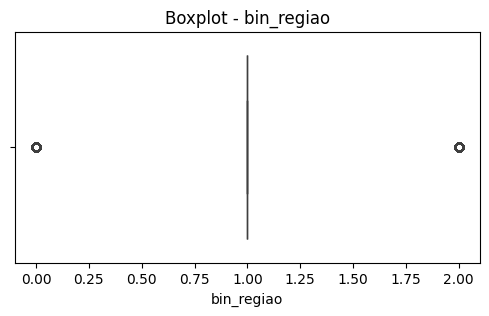

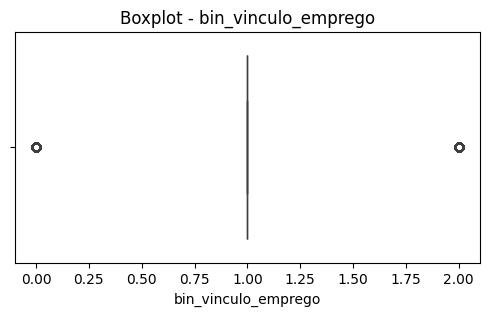

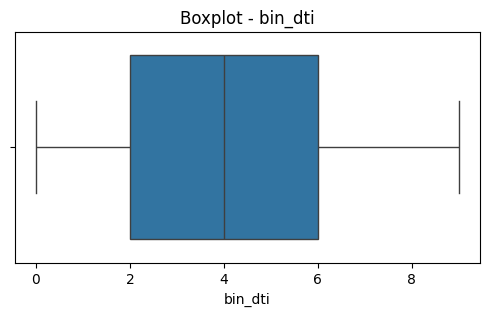

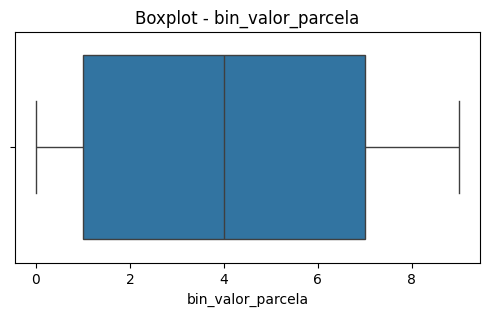

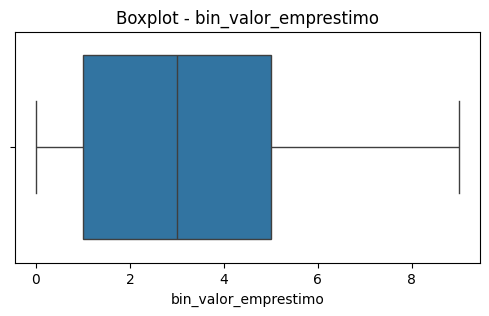

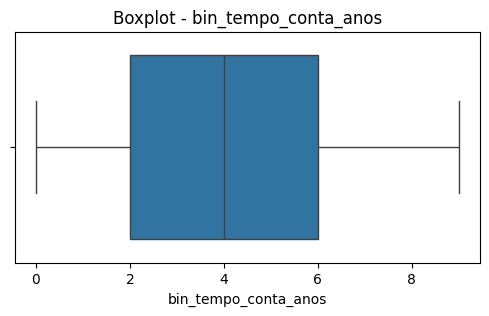

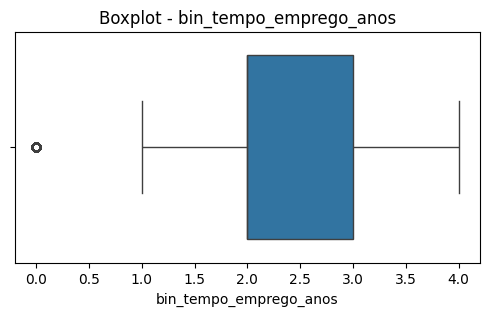

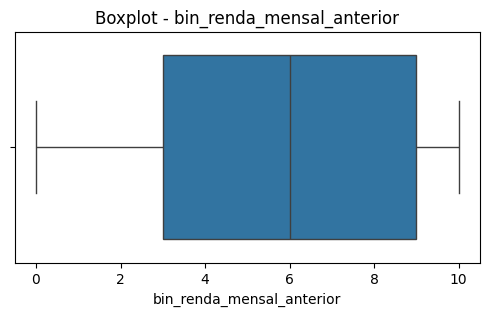

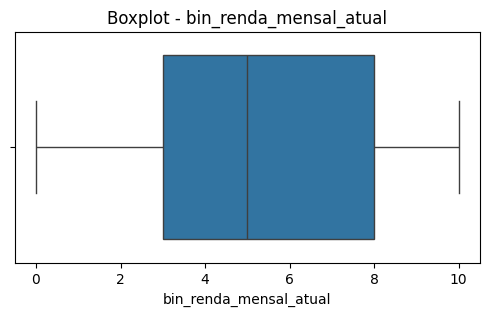

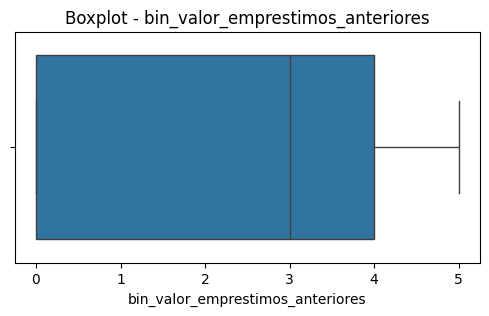

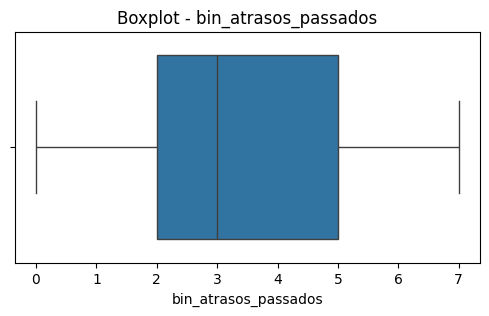

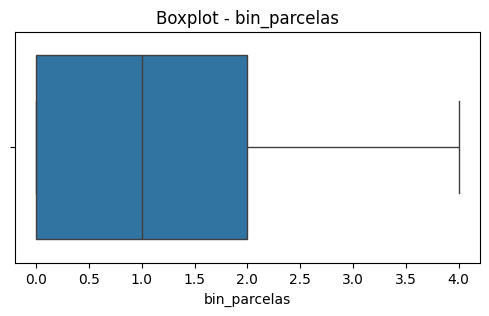

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleciona apenas colunas numéricas que começam com "bin_"
cols_bin = [
    col for col in df_label_bins.select_dtypes(include=[np.number]).columns
    if col.startswith("bin_")
]

# Boxplot para cada coluna filtrada
for col in cols_bin:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df_label_bins[col])
    plt.title(f"Boxplot - {col}")
    plt.show()


In [ ]:
import pandas as pd

def drop_colunas(df: pd.DataFrame, colunas: list):
    """
    Remove do DataFrame as colunas informadas em `colunas`.
    Retorna um novo DataFrame sem as colunas.
    """
    return df.drop(columns=colunas, errors="ignore")  # errors="ignore" evita erro se a coluna não existir

colunas_para_remover = cols_out

df_sem_colunas = drop_colunas(df_label_bins, colunas_para_remover)

display(df_sem_colunas)


,uf,canal,produto,escolaridade,estado_civil,setor,usa_internet_banking,possui_cartao_credito,possui_investimentos,possui_seguro,...,bin_dti,bin_valor_parcela,bin_valor_emprestimo,bin_tempo_conta_anos,bin_renda_mensal_anterior,bin_renda_mensal_atual,bin_valor_emprestimos_anteriores,bin_atrasos_passados,bin_parcelas,tag_etapa_modelagem
0,6,1,4,0,1,4,1,1,1,0,...,4,4,5,3,3,4,3,6,2,0
1,9,0,3,3,2,2,0,0,1,0,...,6,4,5,6,10,2,4,3,1,0
2,7,0,4,1,3,4,1,0,0,0,...,6,1,2,7,8,0,3,5,1,0
3,9,2,3,3,1,6,0,0,0,0,...,3,5,2,4,7,7,0,3,0,0
4,2,2,4,1,0,2,1,1,1,1,...,6,4,5,8,10,2,5,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560536,4,1,4,2,1,4,1,0,0,0,...,3,1,4,7,4,5,0,0,1,1
560537,6,0,4,2,0,6,1,1,0,1,...,3,2,5,8,4,4,3,3,4,1
560538,6,3,1,0,0,0,1,0,0,1,...,7,2,2,7,0,0,0,2,0,1
560539,0,3,1,2,0,3,1,1,0,0,...,3,3,8,1,6,6,0,1,4,1


In [ ]:
# Base de desenvolvimento (baseline)
df_baseline_final = df_sem_colunas[df_sem_colunas["tag_etapa_modelagem"] == 0]

# Base de monitoramento
df_monitoramento_final = df_sem_colunas[df_sem_colunas["tag_etapa_modelagem"] == 1]

# Analisando necessidade de balanceamento (Conclusão: Não há necessidade)
display(df_baseline_final["inadimplente"].value_counts())
print(len(df_baseline_final))

# Analisando necessidade de balanceamento (Conclusão: Não há necessidade)
display(df_monitoramento_final["inadimplente"].value_counts())
print(len(df_monitoramento_final))

inadimplente
0    228134
1    109557
Name: count, dtype: int64

337691


inadimplente
0    150477
1     72373
Name: count, dtype: int64

222850


### 5 - Model Selection

In [ ]:
display(df_baseline_sem_nan)

,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,vinculo_emprego,setor,...,score_credito,parcelas,valor_emprestimo,taxa_juros_mensal,valor_parcela,dti,frequencia_transacoes,valor_emprestimos_anteriores,inadimplente,tempo_emprego_anos
1,6,2,30,2.4,1,4,0,1,1,4,...,449,36,44847.64,0.0400,2371.85,0.114,21,15534.02,1,6.3
5,9,2,44,5.6,0,3,3,2,1,2,...,585,24,42626.56,0.0400,2795.74,0.225,9,26802.44,0,11.2
6,7,3,46,6.7,0,4,1,3,0,4,...,620,24,17433.05,0.0359,1095.89,0.196,11,19454.20,0,1.7
8,9,2,32,3.8,2,3,3,1,1,6,...,690,6,17448.36,0.0263,3181.54,0.072,13,1285.99,0,2.4
10,2,0,29,8.4,2,4,1,0,1,2,...,485,24,36911.00,0.0381,2374.01,0.195,29,9167.06,0,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999978,5,3,28,9.5,0,3,1,2,2,6,...,690,36,24160.89,0.0254,1032.03,0.291,16,6934.72,0,0.0
999981,6,2,44,2.7,3,2,1,0,3,3,...,483,60,26517.19,0.0317,993.31,0.050,16,2206.95,0,0.9
999987,8,3,40,3.0,0,3,1,1,4,1,...,485,12,6814.34,0.0400,726.08,0.012,15,25160.46,0,6.1
999992,8,3,41,2.9,2,2,3,2,1,3,...,871,120,28213.84,0.0147,501.85,0.048,20,25543.87,0,2.3


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    VotingClassifier
)

def avaliar_modelos_cv_multi(
    X: pd.DataFrame,
    y: pd.Series,
    *,
    scoring=("roc_auc",),           # pode ser str ou iterável de strings
    n_splits: int = 5,
    random_state: int = 7,
    n_estimators: int = 200,
    max_features: str | int | float = "sqrt",
    do_plot: bool = True
):
    """
    Roda validação cruzada para um conjunto de modelos e várias métricas.
    Retorna:
      - df_cv_long: DataFrame longo com colunas [Modelo, Metrica, Media, Desvio]
      - scores_dict: dict[modelo][metrica] -> np.array com os scores por fold
    """

    # Normaliza scoring para lista
    if isinstance(scoring, str):
        scoring_list = [scoring]
    else:
        scoring_list = list(scoring)

    # -----------------------
    # Definição dos modelos
    # -----------------------
    base_tree = DecisionTreeClassifier(random_state=random_state)

    reg_log = ('LR',   LogisticRegression(max_iter=200, random_state=random_state))
    knn     = ('KNN',  KNeighborsClassifier())
    cart    = ('CART', DecisionTreeClassifier(random_state=random_state))
    nb      = ('NB',   GaussianNB())
    bag     = ('Bag',  BaggingClassifier(
                    estimator=base_tree,
                    n_estimators=n_estimators,
                    random_state=random_state))
    rf      = ('RF',   RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_features=max_features,
                    random_state=random_state,
                    n_jobs=-1))
    et      = ('ET',   ExtraTreesClassifier(
                    n_estimators=n_estimators,
                    max_features=max_features,
                    random_state=random_state,
                    n_jobs=-1))
    ada     = ('Ada',  AdaBoostClassifier(
                    n_estimators=n_estimators,
                    random_state=random_state))
    gb      = ('GB',   GradientBoostingClassifier(random_state=random_state))

    bases_voting = [
        ('lr',  reg_log[1]),
        ('knn', knn[1]),
        ('nb',  nb[1]),
        ('rf',  rf[1]),
        ('et',  et[1]),
        ('ada', ada[1]),
        ('gb',  gb[1]),
    ]
    vot     = ('Vot',  VotingClassifier(bases_voting, voting='soft', n_jobs=-1))

    pipelines = [
        ('LR',   Pipeline([reg_log])),
        ('KNN',  Pipeline([knn])),
        ('CART', Pipeline([cart])),
        ('NB',   Pipeline([nb])),
        ('Bag',  Pipeline([bag])),
        ('RF',   Pipeline([rf])),
        ('ET',   Pipeline([et])),
        ('Ada',  Pipeline([ada])),
        ('GB',   Pipeline([gb])),
        ('Vot',  Pipeline([vot])),
    ]

    # -----------------------
    # Validação cruzada
    # -----------------------
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    records = []         # para montar df longo
    scores_dict = {}     # {modelo: {metrica: np.array}}
    plot_cache = {}      # para boxplot da 1ª métrica

    for name, model in pipelines:
        try:
            cvres = cross_validate(
                model, X, y,
                cv=cv,
                scoring=scoring_list,
                n_jobs=-1,
                return_train_score=False
            )
            # Guarda scores por métrica
            scores_dict[name] = {}
            for m in scoring_list:
                key = f"test_{m}"
                if key in cvres:
                    vals = cvres[key]
                    scores_dict[name][m] = vals
                    records.append({
                        "Modelo": name,
                        "Metrica": m,
                        "Media": np.mean(vals),
                        "Desvio": np.std(vals)
                    })
            # Para plot: guarda a primeira métrica disponível
            first_metric = scoring_list[0]
            key0 = f"test_{first_metric}"
            if key0 in cvres:
                plot_cache[name] = cvres[key0]

            # Log rápido
            medias = ", ".join([f"{m}={np.mean(scores_dict[name][m]):.3f}" for m in scores_dict[name]])
            print(f"{name}: {medias}")

        except Exception as e:
            print(f"{name}: ERRO -> {e}")

    # DataFrame longo ordenado por média da PRIMEIRA métrica pedida
    df_cv_long = pd.DataFrame(records)
    if not df_cv_long.empty:
        metric0 = scoring_list[0]
        df_cv_long = (
            df_cv_long
            .sort_values(by=["Metrica", "Media"], ascending=[True, False])
            .reset_index(drop=True)
        )
        print(f"\nRanking por métrica (CV={n_splits}):")
        display(df_cv_long[df_cv_long["Metrica"] == metric0]
                .sort_values("Media", ascending=False)
                .reset_index(drop=True))
    else:
        print("\nNenhum modelo foi avaliado com sucesso.")

    # -----------------------
    # Boxplot da primeira métrica (opcional)
    # -----------------------
    if do_plot and len(plot_cache) > 0:
        metric0 = scoring_list[0]
        names_plot = list(plot_cache.keys())
        results_plot = [plot_cache[n] for n in names_plot]

        plt.figure(figsize=(20, 6))
        plt.suptitle(f'Comparação de Modelos (CV={n_splits}, métrica="{metric0}")')
        ax = plt.gca()
        plt.boxplot(results_plot)
        ax.set_xticklabels(names_plot, rotation=90)
        plt.tight_layout()
        plt.show()

    return df_cv_long, scores_dict


#### Sem processo de binning

LR: roc_auc=0.915, recall=0.702, f1=0.753, precision=0.812
KNN: roc_auc=0.761, recall=0.529, f1=0.595, precision=0.680
CART: roc_auc=0.771, recall=0.698, f1=0.691, precision=0.684
NB: roc_auc=0.895, recall=0.547, f1=0.663, precision=0.843
Bag: roc_auc=0.921, recall=0.730, f1=0.773, precision=0.821
RF: roc_auc=0.924, recall=0.732, f1=0.776, precision=0.825
ET: roc_auc=0.924, recall=0.726, f1=0.773, precision=0.828
Ada: roc_auc=0.922, recall=0.732, f1=0.771, precision=0.814
GB: roc_auc=0.927, recall=0.740, f1=0.779, precision=0.824
Vot: roc_auc=0.921, recall=0.671, f1=0.751, precision=0.853

Ranking por métrica (CV=5):


,Modelo,Metrica,Media,Desvio
0,GB,roc_auc,0.927406,0.000707
1,RF,roc_auc,0.924078,0.000968
2,ET,roc_auc,0.924057,0.000944
3,Ada,roc_auc,0.922174,0.001328
4,Bag,roc_auc,0.921040,0.000734
5,Vot,roc_auc,0.920569,0.000814
6,LR,roc_auc,0.915463,0.002642
7,NB,roc_auc,0.894872,0.000730
8,CART,roc_auc,0.771361,0.001221
9,KNN,roc_auc,0.760837,0.001772


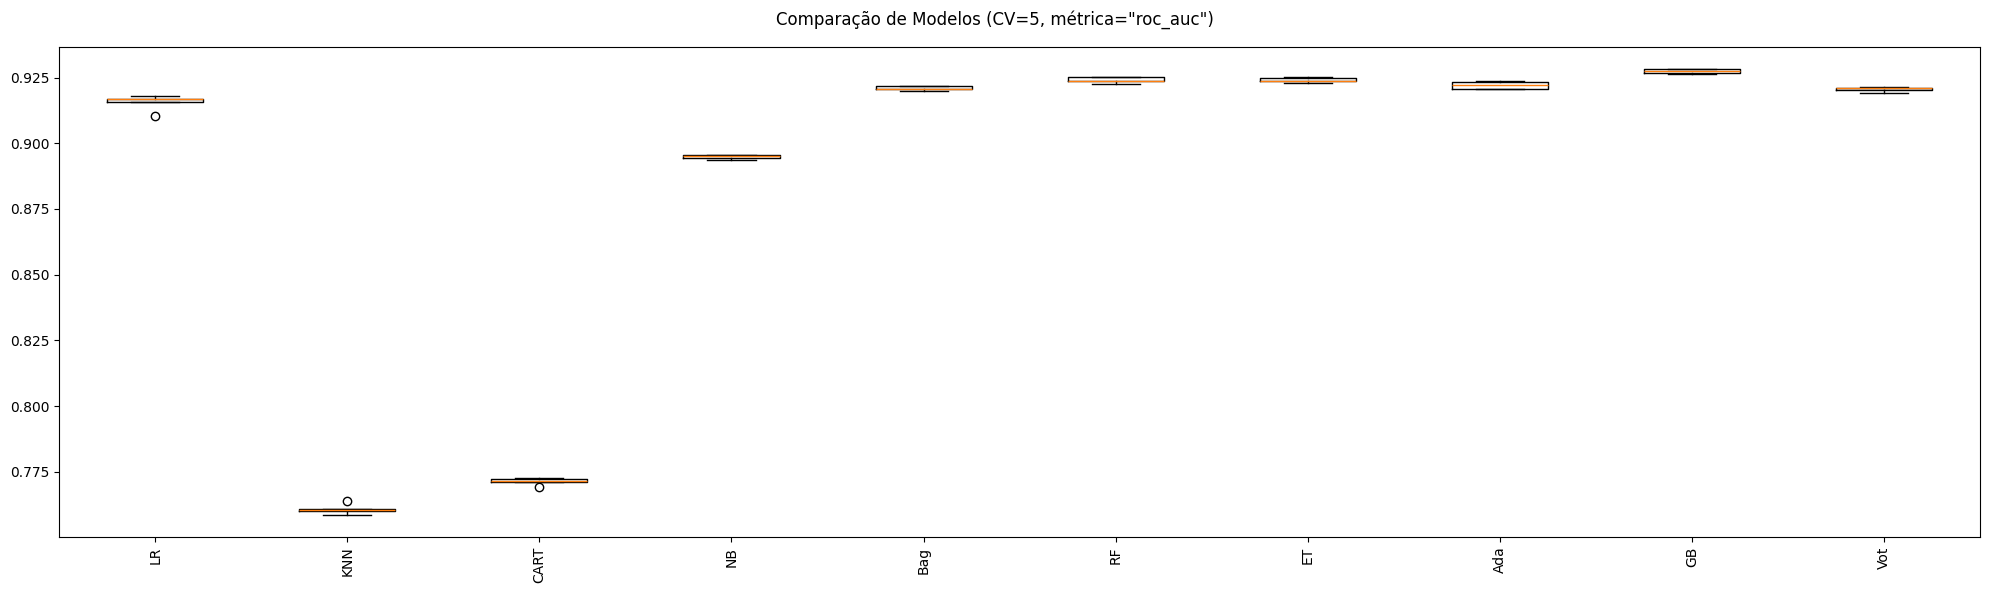

In [ ]:
target_col = "inadimplente"
X = df_baseline_sem_nan.drop(columns=[target_col])
y = df_baseline_sem_nan[target_col]

metrics = ["roc_auc", "recall", "f1", "precision"]

df_long, scores = avaliar_modelos_cv_multi(
    X, y,
    scoring=metrics,
    n_splits=5,
    random_state=7,
    n_estimators=200,
    max_features="sqrt",
    do_plot=True   # faz boxplot da primeira métrica da lista
)


#### Com processo de binning

LR: roc_auc=0.913, recall=0.717, f1=0.750, precision=0.786
KNN: roc_auc=0.871, recall=0.684, f1=0.719, precision=0.759
CART: roc_auc=0.765, recall=0.691, f1=0.682, precision=0.673
NB: roc_auc=0.910, recall=0.777, f1=0.758, precision=0.739
Bag: roc_auc=0.918, recall=0.729, f1=0.768, precision=0.812
RF: roc_auc=0.922, recall=0.731, f1=0.772, precision=0.819
ET: roc_auc=0.922, recall=0.725, f1=0.770, precision=0.822
Ada: roc_auc=0.925, recall=0.735, f1=0.775, precision=0.819
GB: roc_auc=0.926, recall=0.739, f1=0.777, precision=0.818
Vot: roc_auc=0.923, recall=0.745, f1=0.775, precision=0.807

Ranking por métrica (CV=5):


,Modelo,Metrica,Media,Desvio
0,GB,roc_auc,0.925573,0.000767
1,Ada,roc_auc,0.924914,0.000764
2,Vot,roc_auc,0.922931,0.000855
3,RF,roc_auc,0.922445,0.000815
4,ET,roc_auc,0.922014,0.000976
5,Bag,roc_auc,0.918496,0.000766
6,LR,roc_auc,0.912774,0.001074
7,NB,roc_auc,0.909984,0.000988
8,KNN,roc_auc,0.871043,0.000843
9,CART,roc_auc,0.764803,0.000903


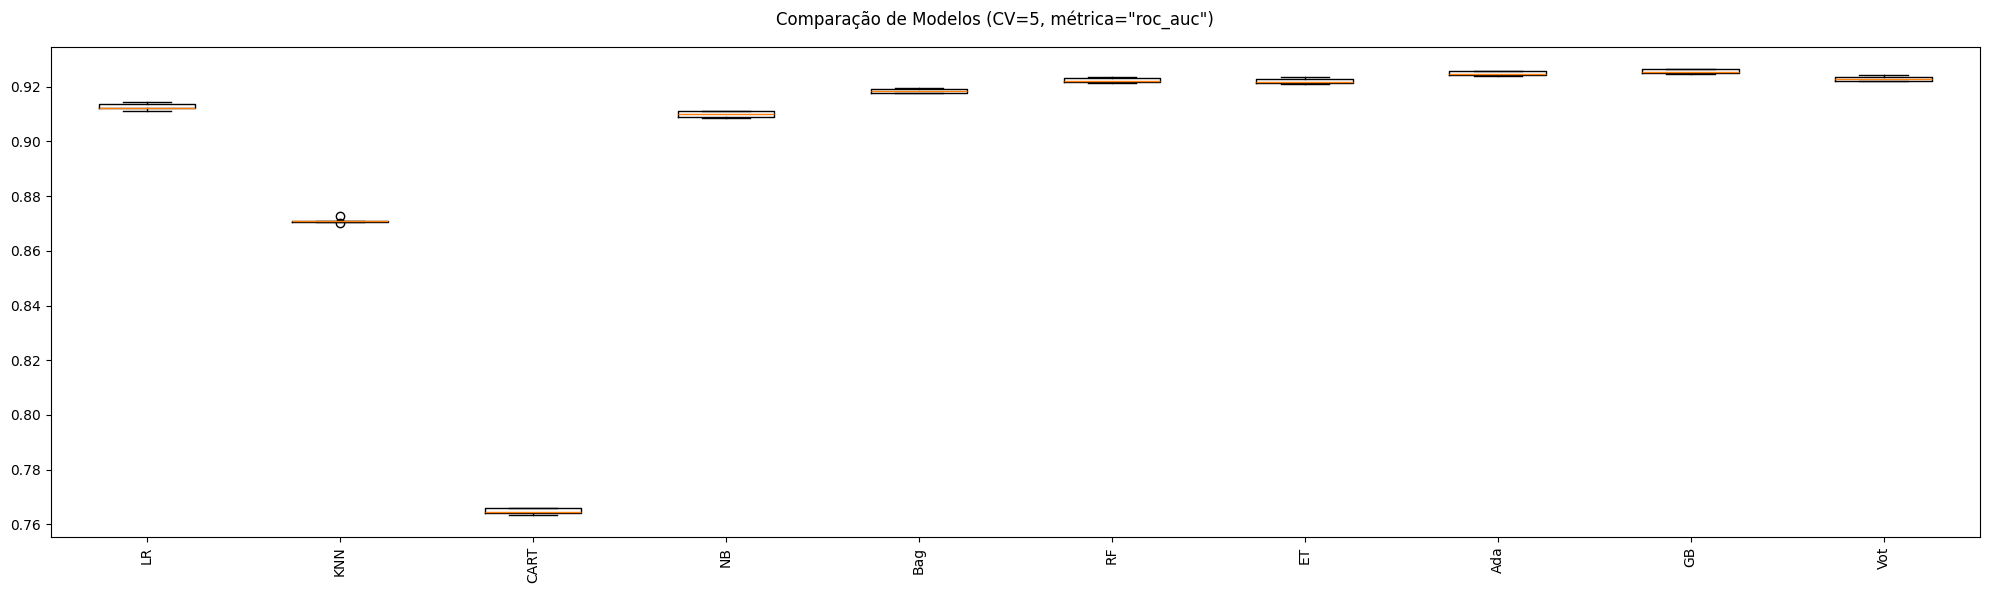

In [ ]:
target_col = "inadimplente"
X = df_baseline_final.drop(columns=[target_col])
y = df_baseline_final[target_col]

metrics = ["roc_auc", "recall", "f1", "precision"]

df_long, scores = avaliar_modelos_cv_multi(
    X, y,
    scoring=metrics,
    n_splits=5,
    random_state=7,
    n_estimators=200,
    max_features="sqrt",
    do_plot=True   # faz boxplot da primeira métrica da lista
)

### 6 - Model Trainning - Hyperparameter Optimization

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Dict, Any

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.ensemble import GradientBoostingClassifier
from joblib import dump

# Successive Halving (opcional e mais rápido)
try:
    from sklearn.experimental import enable_halving_search_cv  # noqa: F401
    from sklearn.model_selection import HalvingGridSearchCV
    _HAS_HALVING = True
except Exception:
    _HAS_HALVING = False


def treinar_gb_com_grid_fast(
    df: pd.DataFrame,
    target_col: str = "inadimplente",
    *,
    train_size: float = 0.60,
    random_state: int = 7,
    cv_splits: int = 3,                 # <- menor que 5 para acelerar
    scoring_refit: str = "roc_auc",     # métrica usada para escolher o melhor
    do_tuning: bool = True,
    use_halving: bool = True,           # <- usa Successive Halving quando possível
    save_path: Optional[str] = None,
    verbose: int = 1
) -> Dict[str, Any]:
    """
    Versão rápida: otimiza GB em < ~1h para ~300k x 30 (estimativa), mantendo qualidade.
    Retorna best_params, best_score_cv, model e métricas (aucroc, precision, recall, f1).
    """

    # -----------------------------
    # 0) X, y e sanidades
    # -----------------------------
    if target_col not in df.columns:
        raise KeyError(f"Coluna de target '{target_col}' não encontrada.")

    X = df.drop(columns=[target_col]).copy()
    y = df[target_col].copy()

    num_cols = X.select_dtypes(include=[np.number]).columns
    X[num_cols] = X[num_cols].astype(np.float32)
    y = y.astype(np.int8)

    non_num = X.columns[~X.columns.isin(num_cols)]
    if len(non_num) > 0:
        raise ValueError(f"Codifique antes as colunas não numéricas: {list(non_num)}")

    # -----------------------------
    # 1) Split 60/40
    # -----------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, stratify=y, random_state=random_state
    )

    # -----------------------------
    # 2) Modelo base (com early stopping)
    # -----------------------------
    base_params = dict(
        n_estimators=300,                # usado também como "recurso" no halving
        learning_rate=0.05,
        max_depth=5,
        min_samples_leaf=10,
        min_samples_split=20,
        subsample=0.8,
        max_features="sqrt",
        random_state=random_state,
        n_iter_no_change=10,
        validation_fraction=0.1,
        tol=1e-4
    )
    gb = GradientBoostingClassifier(**base_params)

    # -----------------------------
    # 3) Grid "leve" (≈64 combos)
    # -----------------------------
    param_grid = {
        "n_estimators":    [200, 300],      # 2
        "learning_rate":   [0.04, 0.06],    # 2
        "max_depth":       [3, 5],          # 2
        "min_samples_leaf":[10, 20],        # 2
        "subsample":       [0.8, 1.0],      # 2
        "max_features":    ["sqrt", None],  # 2
    }
    # Total ≈ 2*2*2*2*2*2 = 64; com CV=3 => 192 fits (bem mais viável)

    # Multi-métrica no CV (refit seleciona a principal)
    scoring = {
        "roc_auc": "roc_auc",
        "f1": "f1",
        "precision": "precision",
        "recall": "recall",
    }

    best_params_ = None
    best_score_cv_ = None

    # -----------------------------
    # 4) Tuning (Grid ou Halving)
    # -----------------------------
    if do_tuning:
        cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

        # grid “leve” para ambos; sem n_estimators quando for Halving
        param_grid = {
            "learning_rate":    [0.04, 0.06],
            "max_depth":        [3, 5],
            "min_samples_leaf": [10, 20],
            "subsample":        [0.8, 1.0],
            "max_features":     ["sqrt", None],
        }

        if use_halving and _HAS_HALVING:
            # Halving: scoring precisa ser UMA métrica (ex.: 'roc_auc')
            search = HalvingGridSearchCV(
                estimator=gb,
                param_grid=param_grid,     # sem n_estimators no grid
                scoring=scoring_refit,     # <- string única
                refit=True,                # refit no melhor por scoring_refit
                cv=cv,
                factor=3,
                resource="n_estimators",   # recurso progressivo
                min_resources=120,
                max_resources=400,         # pode alinhar com base_params['n_estimators']
                aggressive_elimination=True,
                n_jobs=-1,
                verbose=verbose
            )
        else:
            # GridSearchCV aceita múltiplas métricas
            scoring_multi = {
                "roc_auc": "roc_auc",
                "f1": "f1",
                "precision": "precision",
                "recall": "recall",
            }
            # se quiser incluir n_estimators no grid no modo GridSearch, pode:
            param_grid_gs = {
                **param_grid,
                "n_estimators": [200, 300],
            }
            search = GridSearchCV(
                estimator=gb,
                param_grid=param_grid_gs,
                scoring=scoring_multi,
                refit=scoring_refit,   # escolhe qual métrica define o “melhor”
                cv=cv,
                n_jobs=-1,
                verbose=verbose
            )

        search.fit(X_train, y_train)
        best_params_ = search.best_params_
        best_score_cv_ = search.best_score_
        if verbose:
            print(f"\n[TUNING] Melhor {scoring_refit} (CV): {best_score_cv_:.5f}")
            print("[TUNING] Melhores parâmetros:", best_params_)

        gb = search.best_estimator_
    else:
        gb.fit(X_train, y_train)

    # -----------------------------
    # 5) Avaliação no teste (4 métricas)
    # -----------------------------
    y_proba = gb.predict_proba(X_test)[:, 1]
    y_pred50 = (y_proba >= 0.50).astype(int)

    auc_roc = roc_auc_score(y_test, y_proba)
    prec    = precision_score(y_test, y_pred50, zero_division=0)
    rec     = recall_score(y_test, y_pred50, zero_division=0)
    f1      = f1_score(y_test, y_pred50, zero_division=0)

    print(f"\n[TESTE] AUC-ROC={auc_roc:.4f} | Precision={prec:.4f} | Recall={rec:.4f} | F1={f1:.4f}")

    # Curvas e limiares úteis
    fpr, tpr, thr_roc = roc_curve(y_test, y_proba)
    prec_curve, rec_curve, thr_pr = precision_recall_curve(y_test, y_proba)
    youden_thr = thr_roc[np.argmax(tpr - fpr)]
    f1_vals = 2 * (prec_curve * rec_curve) / (prec_curve + rec_curve + 1e-12)
    f1_thr = thr_pr[np.argmax(f1_vals[:-1])]

    def _report_at(thr: float, name: str):
        y_pred = (y_proba >= thr).astype(int)
        cm  = confusion_matrix(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)
        p   = precision_score(y_test, y_pred, zero_division=0)
        r   = recall_score(y_test, y_pred, zero_division=0)
        f1m = f1_score(y_test, y_pred, zero_division=0)
        print(f"[{name}] thr={thr:.4f} | acc={acc:.3f} | prec={p:.3f} | rec={r:.3f} | f1={f1m:.3f}")
        return {"thr": float(thr), "precision": float(p), "recall": float(r), "f1": float(f1m), "cm": cm}

    print("\n— Métricas por limiar —")
    conf_050   = _report_at(0.50,      "T=0.50")
    conf_youd  = _report_at(youden_thr,"Youden")
    conf_f1opt = _report_at(f1_thr,    "F1*")

    # Importâncias
    feat_imp_series = None
    if hasattr(X_train, "columns"):
        feat_imp_series = pd.Series(gb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
        ax = feat_imp_series.head(25).iloc[::-1].plot.barh(figsize=(8,6))
        ax.set_title("GB - Importância de Features (Top 25)")
        ax.set_xlabel("Ganho (feature_importances_)")
        plt.tight_layout(); plt.show()

    if save_path:
        dump(gb, save_path)
        print(f"[OK] Modelo salvo em: {save_path}")

    return {
        "best_params": best_params_,
        "best_score_cv": best_score_cv_,
        "model": gb,
        "metrics": {"aucroc": float(auc_roc), "precision": float(prec), "recall": float(rec), "f1": float(f1)},
        "thresholds": {"thr_050": 0.50, "thr_youden": float(youden_thr), "thr_best_f1": float(f1_thr)},
        "confusions": {"T050": conf_050, "Youden": conf_youd, "F1": conf_f1opt},
        "feature_importances": feat_imp_series
    }


#### Sem processo de binning

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 2
min_resources_: 120
max_resources_: 400
aggressive_elimination: True
factor: 3
----------
iter: 0
n_candidates: 32
n_resources: 120
Fitting 3 folds for each of 32 candidates, totalling 96 fits
----------
iter: 1
n_candidates: 11
n_resources: 120
Fitting 3 folds for each of 11 candidates, totalling 33 fits
----------
iter: 2
n_candidates: 4
n_resources: 120
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 3
n_candidates: 2
n_resources: 360
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[TUNING] Melhor roc_auc (CV): 0.92779
[TUNING] Melhores parâmetros: {'learning_rate': 0.06, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'subsample': 0.8, 'n_estimators': 360}

[TESTE] AUC-ROC=0.9275 | Precision=0.8236 | Recall=0.7434 | F1=0.7814

— Métricas por limiar —
[T=0.50] thr=0.5000 | acc=0.865 | prec=0.824 | rec=0.743 | f1=0.781
[Youden] thr=0.3157 | acc=0.850 | prec=0.735 |

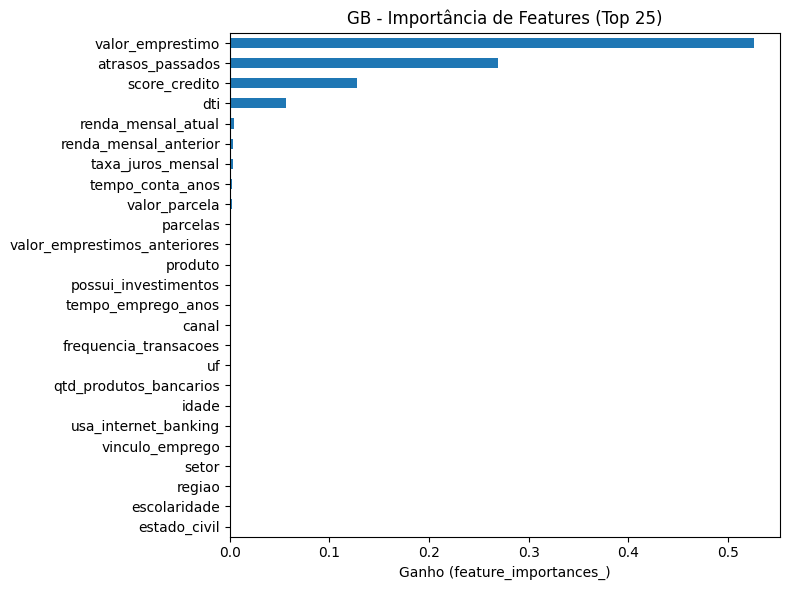

Melhores parâmetros: {'learning_rate': 0.06, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'subsample': 0.8, 'n_estimators': 360}
Score CV médio: 0.9277934008990182
Métricas no teste: {'aucroc': 0.9274903254007494, 'precision': 0.8235621286815826, 'recall': 0.7433539465577437, 'f1': 0.7814051668305788}


In [ ]:
# Chamada básica (com tuning rápido)
res_sem_fte = treinar_gb_com_grid_fast(
    df_baseline_sem_nan,
    target_col="inadimplente",   # coluna alvo
    do_tuning=True,              # ativa o tuning com grid leve
    use_halving=True,            # usa Successive Halving se disponível
    save_path=None,              # ou ex: "gb_model.joblib" para salvar
    verbose=1                    # mostra logs do GridSearch
)

# Acessando resultados
print("Melhores parâmetros:", res_sem_fte["best_params"])
print("Score CV médio:", res_sem_fte["best_score_cv"])
print("Métricas no teste:", res_sem_fte["metrics"])



#### Com processo de binning

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 2
min_resources_: 120
max_resources_: 400
aggressive_elimination: True
factor: 3
----------
iter: 0
n_candidates: 32
n_resources: 120
Fitting 3 folds for each of 32 candidates, totalling 96 fits
----------
iter: 1
n_candidates: 11
n_resources: 120
Fitting 3 folds for each of 11 candidates, totalling 33 fits
----------
iter: 2
n_candidates: 4
n_resources: 120
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 3
n_candidates: 2
n_resources: 360
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[TUNING] Melhor roc_auc (CV): 0.92606
[TUNING] Melhores parâmetros: {'learning_rate': 0.06, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 20, 'subsample': 0.8, 'n_estimators': 360}

[TESTE] AUC-ROC=0.9257 | Precision=0.8192 | Recall=0.7400 | F1=0.7776

— Métricas por limiar —
[T=0.50] thr=0.5000 | acc=0.863 | prec=0.819 | rec=0.740 | f1=0.778
[Youden] thr=0.3126 | acc=0.847 | prec=0.729 |

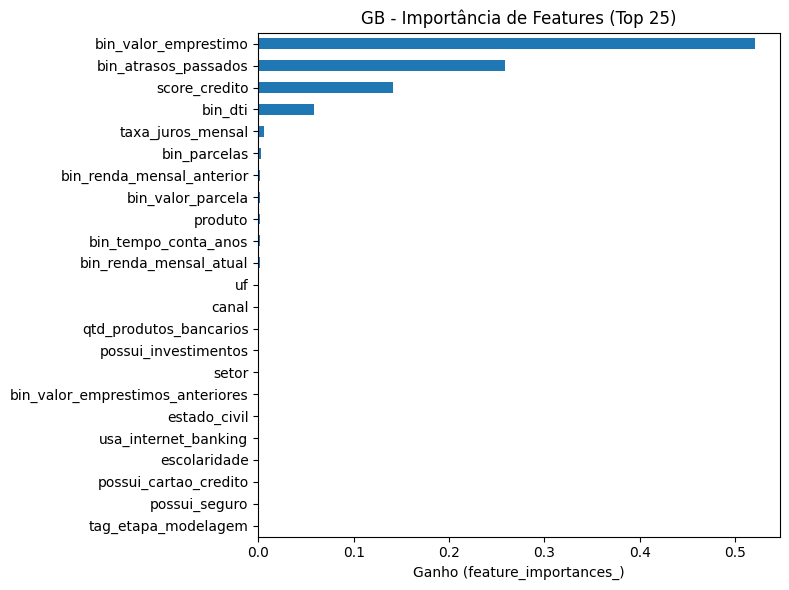

Melhores parâmetros: {'learning_rate': 0.06, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 20, 'subsample': 0.8, 'n_estimators': 360}
Score CV médio: 0.9260551036933687
Métricas no teste: {'aucroc': 0.9256722057986568, 'precision': 0.8192360163710778, 'recall': 0.739953905483422, 'f1': 0.7775792818176368}


In [ ]:
# Chamada básica (com tuning rápido)
res_com_fte = treinar_gb_com_grid_fast(
    df_baseline_final,
    target_col="inadimplente",   # coluna alvo
    do_tuning=True,              # ativa o tuning com grid leve
    use_halving=True,            # usa Successive Halving se disponível
    save_path=None,              # ou ex: "gb_model.joblib" para salvar
    verbose=1                    # mostra logs do GridSearch
)

# Acessando resultados
print("Melhores parâmetros:", res_com_fte["best_params"])
print("Score CV médio:", res_com_fte["best_score_cv"])
print("Métricas no teste:", res_com_fte["metrics"])



### 7 - Model Trainning - Final

In [ ]:
import numpy as np
import pandas as pd
from typing import Dict, Optional
from sklearn.ensemble import GradientBoostingClassifier
from joblib import dump

def treinar_gb_final(
    df: pd.DataFrame,
    best_params: Dict,
    target_col: str = "inadimplente",
    *,
    random_state: int = 7,
    save_path: Optional[str] = None
) -> GradientBoostingClassifier:
    """
    Treina um GradientBoostingClassifier usando 'best_params' já encontrados.
    - df: DataFrame completo (features + target)
    - best_params: dicionário de hiperparâmetros ótimos (ex.: res['best_params'])
    - target_col: nome da coluna alvo
    - random_state: semente (reprodutibilidade)
    - save_path: se informado, salva o modelo em disco (joblib)

    Retorna:
        modelo treinado (GradientBoostingClassifier)
    """
    if target_col not in df.columns:
        raise KeyError(f"Target '{target_col}' não encontrado no DataFrame.")

    X = df.drop(columns=[target_col]).copy()
    y = df[target_col].copy()

    # conversão leve (assume que já está pré-processado e numérico)
    num_cols = X.select_dtypes(include=[np.number]).columns
    X[num_cols] = X[num_cols].astype(np.float32)
    y = y.astype(np.int8)

    non_num = X.columns[~X.columns.isin(num_cols)]
    if len(non_num) > 0:
        raise ValueError(f"Existem colunas não numéricas: {list(non_num)}. Codifique antes.")

    # instancia com os melhores parâmetros (mantém random_state)
    gb = GradientBoostingClassifier(random_state=random_state, **best_params)
    gb.fit(X, y)  # treina no DATASET INTEIRO

    if save_path:
        dump(gb, save_path)

    return gb


In [ ]:
# Calcula métricas durante o período em produção do modelo

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

def calcular_metricas(y_true, y_proba, thr: float = 0.50):
    """
    Calcula f1, recall, precision e aucroc no limiar especificado.
    """
    y_pred = (y_proba >= thr).astype(int)
    return {
        "aucroc": float(roc_auc_score(y_true, y_proba)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "f1": float(f1_score(y_true, y_pred, zero_division=0))
    }

#### Sem processo de binning

In [ ]:
best_params = res_sem_fte["best_params"]
gb_final_sem_fte = treinar_gb_final(
    df_baseline_sem_nan,          # seu DF completo
    best_params=best_params,
    target_col="inadimplente",
    # random_state=7,
    save_path="gb_final_sem_fte.joblib"   # opcional
)


In [ ]:
# Remove a coluna de target e valores NaN
df_monitoramento_encoded_sem_target = (
    df_monitoramento_encoded
    .drop(columns=["inadimplente"], errors="ignore")
    .dropna()
)

# Previsões
y_proba = gb_final_sem_fte.predict_proba(df_monitoramento_encoded_sem_target)[:, 1]
y_pred  = gb_final_sem_fte.predict(df_monitoramento_encoded_sem_target)

display(y_proba)
display(y_pred)

array([0.96972718, 0.01502271, 0.16925983, ..., 0.05475737, 0.23343992,
       0.1555669 ], shape=(193457,))

array([1, 0, 0, ..., 0, 0, 0], shape=(193457,), dtype=int8)

In [ ]:
# 1) dropa todas as linhas com NaN
df_monitoramento_sem_nan = df_monitoramento_encoded.dropna()

y_true  = df_monitoramento_sem_nan["inadimplente"].astype(int).values
X_novo  = df_monitoramento_sem_nan.drop(columns=["inadimplente"], errors="ignore")
y_proba = gb_final_sem_fte.predict_proba(X_novo)[:, 1]

metricas = calcular_metricas(y_true, y_proba, thr=0.50)
print(metricas)

{'aucroc': 0.9280616708130408, 'precision': 0.8297334600010755, 'recall': 0.7366444405544328, 'f1': 0.7804228344067168}


#### Com processo de binning

In [ ]:
best_params = res_com_fte["best_params"]
gb_final_com_fte = treinar_gb_final(
    df_baseline_final,          # seu DF completo
    best_params=best_params,
    target_col="inadimplente",
    # random_state=7,
    save_path="gb_final_com_fte.joblib"   # opcional
)

In [ ]:
# Remove a coluna de target
df_monitoramento_final_sem_target = df_monitoramento_final.drop(columns=["inadimplente"], errors="ignore")

# Previsões
y_proba = gb_final_com_fte.predict_proba(df_monitoramento_final_sem_target)[:, 1]
y_pred  = gb_final_com_fte.predict(df_monitoramento_final_sem_target)

display(y_proba)
display(y_pred)


array([0.95837008, 0.013693  , 0.19870899, ..., 0.05852529, 0.33458345,
       0.17433027], shape=(222850,))

array([1, 0, 0, ..., 0, 0, 0], shape=(222850,), dtype=int8)

In [ ]:
y_true  = df_monitoramento_final["inadimplente"].astype(int).values
X_novo  = df_monitoramento_final.drop(columns=["inadimplente"], errors="ignore")
y_proba = gb_final_com_fte.predict_proba(X_novo)[:, 1]

metricas = calcular_metricas(y_true, y_proba, thr=0.50)
print(metricas)


{'aucroc': 0.9259302293002992, 'precision': 0.8217849266690314, 'recall': 0.736282867920357, 'f1': 0.7766878498134329}
